# Amazon Apparel Recommendation

## [ CONTENTS ] 

1. About the dataset<br>
2. Real-world/Business objectives and constraints<br>
3. Data and Libraries Loading<br>
4. Exploratory Data Analysis
5. Text Preprocessing<br>
6. Text Based Product Similarity<br>
7. Text Semantic Based Product Similarity<br>
8. Visual Feature Based Product Similarity<br>
9. Weighted Features Based Product Similarity<br>
10. Conclusion<br>

## 1.About the dataset

**1. Data :** The dataset is extracted from Amazon website under apparel section.<br>
**2. Task :** Recommend people similar products based on the search result.<br>
**3. Data Overview :** The dataset has 19 features. And they are 'asin', 'author', 'availability',   'availability_type', 'brand', 'color', 'editorial_reivew', 'editorial_review', 'formatted_price',
'large_image_url', 'manufacturer', 'medium_image_url', 'model','product_type_name', 'publisher', 'reviews','sku', 'small_image_url','title'. Among these I will use only 6 features and they are:<br>
   * asin  ( Amazon standard identification number)
   * brand ( brand to which the product belongs to )
   * color ( Color information of apparel, it can contain many colors as   a value ex: red and black stripes ) 
   * product_type_name (type of the apperal, ex: SHIRT/TSHIRT )
   * medium_image_url  ( url of the image )
   * title (title of the product.)
   * formatted_price (price of the product)

## 2. Real-world/Business objective and constraints

**Objective:** Recommend people similar product based on their searched item.<br>
<br>
**Constraints:**<br>
* Some Latency constraints.

## 3. Data and Libraries Loading

In [36]:
import warnings 
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 
import scipy
import matplotlib
import matplotlib.pyplot as plt
import nltk
import math
import time
import re 
import os 
import seaborn as sns
import plotly
import plotly.figure_factory as ff
import requests
import PIL

from PIL import Image
from matplotlib.pyplot import imshow
from io import BytesIO
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
from plotly.graph_objs import Layout, Scatter
plotly.offline.init_notebook_mode(connected = True)

In [2]:
data = pd.read_json("../tops_fashion.json")
print("Number of Data-points in the given dataset is : ", data.shape[0])
print("Number of Features in the given dataset is :", data.shape[1])

Number of Data-points in the given dataset is :  183138
Number of Features in the given dataset is : 19


In [3]:
data.columns

Index(['asin', 'author', 'availability', 'availability_type', 'brand', 'color',
       'editorial_reivew', 'editorial_review', 'formatted_price',
       'large_image_url', 'manufacturer', 'medium_image_url', 'model',
       'product_type_name', 'publisher', 'reviews', 'sku', 'small_image_url',
       'title'],
      dtype='object')

In [4]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [5]:
data.head()

asin         brand              color  \
0  B016I2TS4W         FNC7C               None   
1  B01N49AI08  FIG Clothing               None   
2  B01JDPCOHO  FIG Clothing               None   
3  B01N19U5H5       Focal18               None   
4  B004GSI2OS   FeatherLite  Onyx Black/ Stone   

                                    medium_image_url product_type_name  \
0  https://images-na.ssl-images-amazon.com/images...             SHIRT   
1  https://images-na.ssl-images-amazon.com/images...             SHIRT   
2  https://images-na.ssl-images-amazon.com/images...             SHIRT   
3  https://images-na.ssl-images-amazon.com/images...             SHIRT   
4  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                               title formatted_price  
0  Minions Como Superheroes Ironman Long Sleeve R...            None  
1                      FIG Clothing Womens Izo Tunic            None  
2                        FIG Clothing Womens Won Top            None  
3  Focal18 Sailor Collar Bubble Sleeve Blouse Shi...            None  
4  Featherlite Ladies' Long Sleeve Stain Resistan...          $26.26

## 4. Exploratory Data Analysis (EDA)

### 4.1 Basic stats of Features

### [A] Basic stats for the feature: product_type_name

In [6]:
data["product_type_name"].describe()

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object

In [7]:
data["product_type_name"].unique()

array(['SHIRT', 'SWEATER', 'APPAREL', 'OUTDOOR_RECREATION_PRODUCT',
       'BOOKS_1973_AND_LATER', 'PANTS', 'HAT', 'SPORTING_GOODS', 'DRESS',
       'UNDERWEAR', 'SKIRT', 'OUTERWEAR', 'BRA', 'ACCESSORY',
       'ART_SUPPLIES', 'SLEEPWEAR', 'ORCA_SHIRT', 'HANDBAG',
       'PET_SUPPLIES', 'SHOES', 'KITCHEN', 'ADULT_COSTUME',
       'HOME_BED_AND_BATH', 'MISC_OTHER', 'BLAZER',
       'HEALTH_PERSONAL_CARE', 'TOYS_AND_GAMES', 'SWIMWEAR',
       'CONSUMER_ELECTRONICS', 'SHORTS', 'HOME', 'AUTO_PART',
       'OFFICE_PRODUCTS', 'ETHNIC_WEAR', 'BEAUTY',
       'INSTRUMENT_PARTS_AND_ACCESSORIES', 'POWERSPORTS_PROTECTIVE_GEAR',
       'SHIRTS', 'ABIS_APPAREL', 'AUTO_ACCESSORY', 'NONAPPARELMISC',
       'TOOLS', 'BABY_PRODUCT', 'SOCKSHOSIERY',
       'POWERSPORTS_RIDING_SHIRT', 'EYEWEAR', 'SUIT', 'OUTDOOR_LIVING',
       'POWERSPORTS_RIDING_JACKET', 'HARDWARE', 'SAFETY_SUPPLY',
       'ABIS_DVD', 'VIDEO_DVD', 'GOLF_CLUB', 'MUSIC_POPULAR_VINYL',
       'HOME_FURNITURE_AND_DECOR', 'TABLET_COMPUTER',

In [8]:
product_type_count = Counter(data["product_type_name"])
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

In [9]:
data["product_type_name"].isnull().sum()

0

### [B] Basic stats for the feature: brand

In [10]:
data["brand"].describe()

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object

In [11]:
brand_count = Counter(data["brand"])
brand_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

In [12]:
data["brand"].isnull().sum()

151

### [C]  Basic stats for the feature: color

In [13]:
data["color"].describe()

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object

In [14]:
color_count = Counter(data["color"])
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

In [15]:
data["color"].isnull().sum()

118182

### [D]  Basic stats for the feature: formatted_price

In [16]:
data["formatted_price"].describe()

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object

In [17]:
price_count = Counter(data["formatted_price"])
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

In [18]:
data["formatted_price"].isnull().sum()

154743

### [E] Basic stats for the feature: title

In [19]:
data["title"].describe()

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object

In [20]:
data["title"].isnull().sum()

0

In [21]:
data["asin"].isnull().sum()

0

In [22]:
data["medium_image_url"].isnull().sum()

0

In [23]:
data.fillna('Unknown', inplace = True)

In [24]:
data.isnull().any()

asin                 False
brand                False
color                False
medium_image_url     False
product_type_name    False
title                False
formatted_price      False
dtype: bool

### 4.2 Remove Near Duplicate Items

In [19]:
data.to_pickle("../180k_apparel_data")

In [26]:
import multiprocessing.dummy as mp 

def download_img(num):
    
    url = data.iloc[num]['medium_image_url']
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.save('../image'+ data.iloc[num]['asin'] +'.jpeg')  

if __name__ == "__main__":
    
    p = mp.Pool(8)
    p.map(download_img, range(0, 183138))
    p.close()
    p.join()

In [28]:
data.duplicated('title').sum()

7153

In [30]:
data[data.duplicated('title')].head(10)

asin             brand         color  \
244  B003BTPVHE       FeatherLite  Pacific Blue   
261  B01M1K2AOX  fashion t shirts         Black   
348  B001LOT186      Fitness Etc.          Pink   
371  B074KGP484     Fashion Story         Black   
442  B074K6MY5V     Fashion Story         Green   
449  B003BTPVEM       FeatherLite  Pacific Blue   
465  B06XHYVRK9       Fashion2ne1         White   
510  B01G9CLYVQ          FASCIINO           Red   
605  B071W7B6DQ             Fever       Unknown   
637  B0728P1LBP    findersKEEPERS       Unknown   

                                      medium_image_url     product_type_name  \
244  https://images-na.ssl-images-amazon.com/images...                 SHIRT   
261  https://images-na.ssl-images-amazon.com/images...  BOOKS_1973_AND_LATER   
348  https://images-na.ssl-images-amazon.com/images...                 SHIRT   
371  https://images-na.ssl-images-amazon.com/images...               SWEATER   
442  https://images-na.ssl-images-amazon.com/images...               SWEATER   
449  https://images-na.ssl-images-amazon.com/images...                 SHIRT   
465  https://images-na.ssl-images-amazon.com/images...                 SHIRT   
510  https://images-na.ssl-images-amazon.com/images...                 SHIRT   
605  https://images-na.ssl-images-amazon.com/images...               APPAREL   
637  https://images-na.ssl-images-amazon.com/images...                 SHIRT   

                                                 title formatted_price  
244  FeatherLite Ladies Long Sleeve Stain Resistant...          $22.91  
261  Annehoney Donald Trump poster fashion Women's ...          $22.89  
348             Ladies Cotton Tank 2x1 Ribbed Tank Top          $11.99  
371  Fashion Story Women's Casual Oversized Long Ba...           $8.99  
442  Fashion Story Women's Casual Oversized Long Ba...           $8.99  
449  FeatherLite Ladies Long Sleeve Stain Resistant...          $22.78  
465  Bling Happy Easter Neon Rhinestones & Studs Eg...         Unknown  
510  FASCIINO® Beauty and Beast Red Family Matching...         Unknown  
605                      Fever Ladies’ Roll Tab Blouse         Unknown  
637                  findersKEEPERS Women's Curtis Top         Unknown

### [A]  These shirts are exactly same except in size (S, M,L,XL)

In [36]:
dup_indx = data[data.duplicated('title')].index

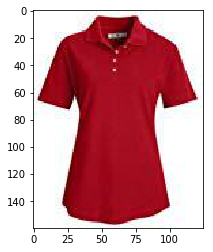

In [41]:
img1 = Image.open('../image/imageB00AQ4GMCK.jpeg', 'r')
img2 = Image.open('../image/imageB00AQ4GMTS.jpeg', 'r')
img3 = Image.open('../image/imageB00AQ4GMLQ.jpeg', 'r')
img4 = Image.open('../image/imageB00AQ4GN3I.jpeg', 'r')
imshow(np.asarray(img1))

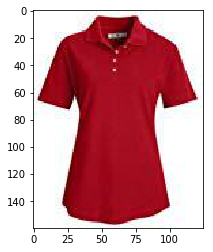

In [42]:
imshow(np.asarray(img2))

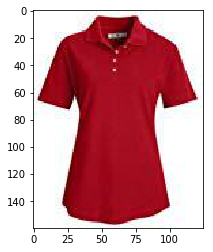

In [43]:
imshow(np.asarray(img3))

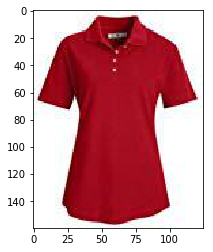

In [44]:
imshow(np.asarray(img4))

### [B]These shirts exactly same except in color

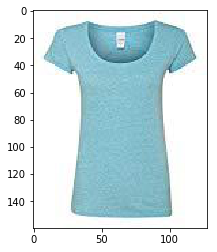

In [45]:
img1 = Image.open('../image/imageB00G278GZ6.jpeg', 'r')
img2 = Image.open('../image/imageB00G278W6O.jpeg', 'r')
img3 = Image.open('../image/imageB00G278Z2A.jpeg', 'r')
img4 = Image.open('../image/imageB00G2786X8.jpeg', 'r')
imshow(np.asarray(img1))

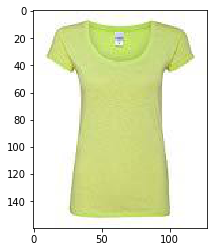

In [46]:
imshow(np.asarray(img2))

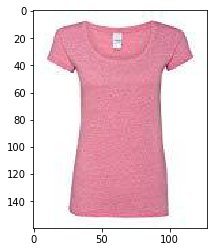

In [47]:
imshow(np.asarray(img3))

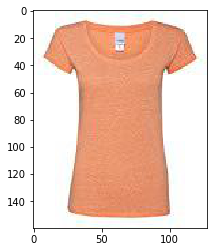

In [48]:
imshow(np.asarray(img4))

In [49]:
data.drop([78412], axis = 0, inplace = True)

In [ ]:
# Remove All products with very few words in title
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

In [51]:
# Sort the whole data based on title (alphabetical order of title) 
data.sort_values('title', inplace = True, ascending = False)
data.head()

asin       brand  color  \
27547  B073W7P8KK  Nation LTD   Blue   
31277  B01M0PWMZ8      Anglin  White   
30453  B01M02GWRG      Anglin  White   
32485  B01N0ADXM0      Anglin    Red   
26767  B01MTQAU86      Anglin  Black   

                                        medium_image_url product_type_name  \
27547  https://images-na.ssl-images-amazon.com/images...             DRESS   
31277  https://images-na.ssl-images-amazon.com/images...             SHIRT   
30453  https://images-na.ssl-images-amazon.com/images...             SHIRT   
32485  https://images-na.ssl-images-amazon.com/images...             SHIRT   
26767  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                   title formatted_price  
27547  ❀Nation Women Stripe Blouse Long Sleeve Shirt ...         Unknown  
31277  ✽ANGLIN✽ Women Striped Floral Long Sleeve Roun...         Unknown  
30453  ✽ANGLIN✽ Women Striped Floral Long Sleeve Roun...         Unknown  
32485  ✽ANGLIN✽ Women Fashion Stripe Dress Round Coll...         Unknown  
26767  ✽ANGLIN✽ Women Autumn Winter Christmas Printin...         Unknown

### [C] Some examples of dupliacte titles that differ only in the last few words.

<pre>
Titles 1:
16. woman's place is in the house and the senate shirts for Womens XXL White
17. woman's place is in the house and the senate shirts for Womens M Grey

Title 2:
25. tokidoki The Queen of Diamonds Women's Shirt X-Large
26. tokidoki The Queen of Diamonds Women's Shirt Small
27. tokidoki The Queen of Diamonds Women's Shirt Large

Title 3:
61. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
62. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
63. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
64. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
</pre>

In [53]:
indices = []
for i,row in data.iterrows():
    indices.append(i)

In [54]:
import itertools

stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    # store the list of words of ith string in a,
    a = data['title'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:

        # store the list of words of jth string in b
        b = data['title'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        # count is used to store the number of words that are matched in both strings
        count  = 0
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(data['asin'].loc[indices[i]])

            # if the comaprision between is between num_data_points, num_data_points-1 strings and they differ in more than 2 words we include both
            if j == num_data_points - 1: 
                stage1_dedupe_asins.append(data['asin'].loc[indices[j]])

            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [56]:
len(stage1_dedupe_asins)

154706

In [57]:
data.shape

(183137, 7)

In [59]:
data = data[data['asin'].isin(stage1_dedupe_asins)]

In [60]:
data.shape

(154706, 7)

### [D] Further Duplicate Removal

<pre>

In the previous cell, we sorted whole data in alphabetical order of  titles.Then, we removed titles which are adjacent and very similar title

But there are some products whose titles are not adjacent but very similar.

Examples:

Titles-1
86261.  UltraClub Women's Classic Wrinkle-Free Long Sleeve Oxford Shirt, Pink, XX-Large
115042. UltraClub Ladies Classic Wrinkle-Free Long-Sleeve Oxford Light Blue XXL

TItles-2
75004.  EVALY Women's Cool University Of UTAH 3/4 Sleeve Raglan Tee
109225. EVALY Women's Unique University Of UTAH 3/4 Sleeve Raglan Tees
120832. EVALY Women's New University Of UTAH 3/4-Sleeve Raglan Tshirt

</pre>

In [61]:
data.to_pickle('../154k_apperal_data')

In [62]:
indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!= 0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [66]:
len(stage2_dedupe_asins)

136785

In [67]:
data = data[data['asin'].isin(stage2_dedupe_asins)]

## 5. Text Preprocessing

In [72]:
data.to_pickle('../136k_apperal_data')

In [74]:
stop_words = set(stopwords.words('english'))
print(stop_words)

def nlp_preprocessing(total_txt, index, column):
    if type(total_txt) is not int:
        string = ""
        for words in total_txt.split():
            word = ("".join(w for w in words if w.isalnum()))
            word = word.lower()
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

{"it's", 'they', 'them', 'when', 'be', 'some', 'further', "doesn't", 'for', "needn't", 'over', 'you', 'so', 'aren', 'now', 'y', 'into', 'this', 'a', 'above', "you're", 'as', 's', 'how', 'did', 'he', 'before', 'can', 'again', 'having', 'don', 'his', 'but', 'am', 'hers', 'where', 'if', 'won', 'do', 'itself', 'few', 'hasn', 'ours', 'm', "she's", "don't", 'was', "hadn't", "wouldn't", 'her', 'doing', 'shouldn', 'needn', 'been', 'didn', "hasn't", 'to', 'has', 'd', 'an', 'then', "you've", 'the', 'i', "haven't", 'because', 'both', 've', 'yourself', 'their', 'mustn', 't', 'once', 'haven', 'more', "should've", "aren't", 'mightn', 'not', 'most', 'all', 'until', 'these', 'ain', 'will', 'ourselves', 'hadn', "couldn't", "that'll", 'other', 'same', "didn't", 'it', 'those', 'or', 'about', "weren't", "you'll", 'there', 'o', 'whom', 'wouldn', 'couldn', 'through', 'than', 'its', 'himself', 'during', 'shan', "wasn't", 'after', 'we', 'very', 'themselves', 'why', 'each', 'theirs', 'doesn', 'up', 'just', 'fr

In [75]:
start_time = time.clock()
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
print(time.clock() - start_time, "seconds")

327.1285190000199 seconds


In [76]:
data.head()

asin       brand  color  \
27547  B073W7P8KK  Nation LTD   Blue   
31277  B01M0PWMZ8      Anglin  White   
32485  B01N0ADXM0      Anglin    Red   
26767  B01MTQAU86      Anglin  Black   
82343  B073W7HXFM  Nation LTD  Black   

                                        medium_image_url product_type_name  \
27547  https://images-na.ssl-images-amazon.com/images...             DRESS   
31277  https://images-na.ssl-images-amazon.com/images...             SHIRT   
32485  https://images-na.ssl-images-amazon.com/images...             SHIRT   
26767  https://images-na.ssl-images-amazon.com/images...             SHIRT   
82343  https://images-na.ssl-images-amazon.com/images...           SWEATER   

                                                   title formatted_price  
27547  nation women stripe blouse long sleeve shirt l...         Unknown  
31277  anglin women striped floral long sleeve round ...         Unknown  
32485  anglin women fashion stripe dress round collar...         Unknown  
26767  anglin women autumn winter christmas printing ...         Unknown  
82343  nation women sleeveless shirt jumpsuit bodysui...         Unknown

In [77]:
data.to_pickle('../136k_apperal_data_preprocessed')

### [A] Stemming

In [78]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

## 6. Text Based Product Similarity

In [57]:
def display_img(indx, ax, fig):
    img = Image.open('../image/image' + data.asin[indx] + '.jpeg')
    plt.imshow(img)
    
def plot_heatmap(keys, values, labels, indx, text):
    gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[4, 1]) 
    fig = plt.figure(figsize=(25, 3))
        
    ax = plt.subplot(gs[0])   
    ax = sns.heatmap(np.array([values]), annot=np.array([labels]), cmap = sns.color_palette("GnBu_d"))
    ax.set_xticklabels(keys) 
    ax.set_title(text)
        
    ax = plt.subplot(gs[1])
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
        
    display_img(indx, ax, fig)
    plt.show()
    
    
def plot_heatmap_image(doc_id, vec1, vec2, text, indx, model):
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    for i in vec2:
        if i not in intersection:
            vec2[i] = 0

    keys = list(vec2.keys())
    values = [vec2[x] for x in vec2.keys()]
    
    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():           
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, indx, text)


def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words)


def get_result(doc_id, content_a, content_b, indx, model):
    text1 = content_a
    text2 = content_b
    
    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, text2, indx, model)

### [A] Bag of Words (BoW) on product titles

In [80]:
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape()

(136785, 40796)

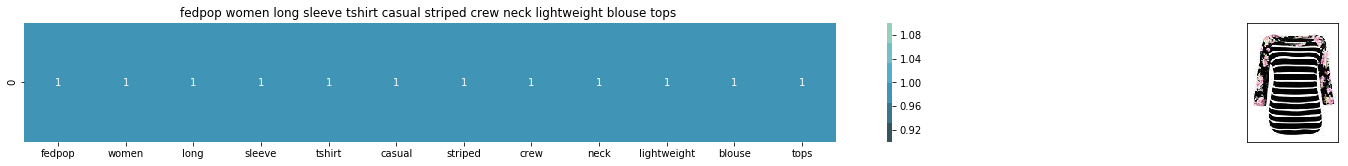

ASIN : B073XZSZXR
Brand: Fedpop
Title: fedpop women long sleeve tshirt casual striped crew neck lightweight blouse tops 
Euclidean similarity with the query image : 0.0


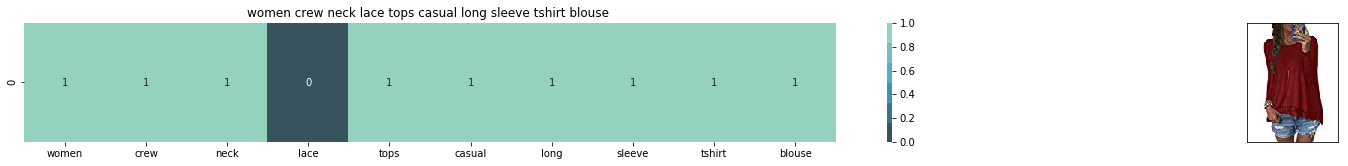

ASIN : B01L8SF5SY
Brand: Yidarton
Title: women crew neck lace tops casual long sleeve tshirt blouse 
Euclidean similarity with the query image : 2.0


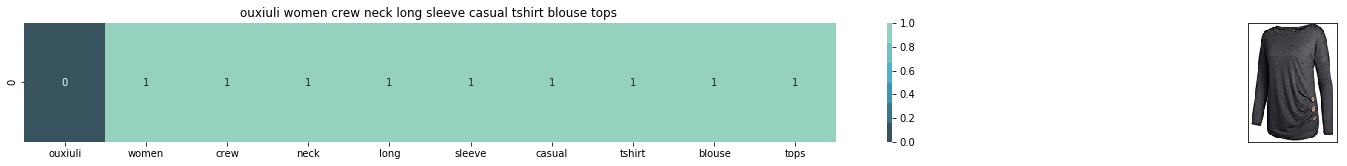

ASIN : B0755CMXSL
Brand: ouxiuli
Title: ouxiuli women crew neck long sleeve casual tshirt blouse tops 
Euclidean similarity with the query image : 2.0


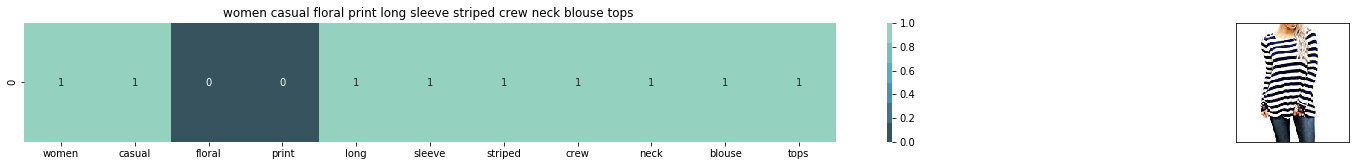

ASIN : B0757MFLW4
Brand: FAROOT
Title: women casual floral print long sleeve striped crew neck blouse tops 
Euclidean similarity with the query image : 2.23606797749979


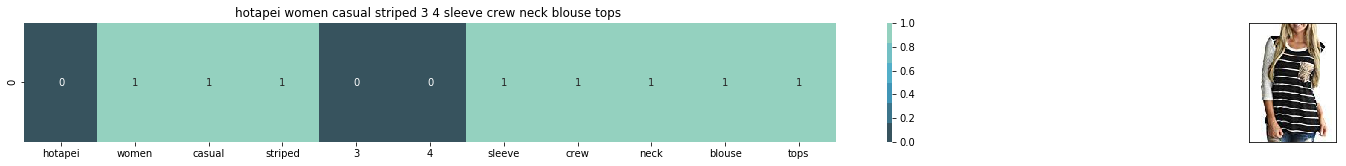

ASIN : B0735H7MHJ
Brand: HOTAPEI
Title: hotapei women casual striped 3 4 sleeve crew neck blouse tops 
Euclidean similarity with the query image : 2.23606797749979


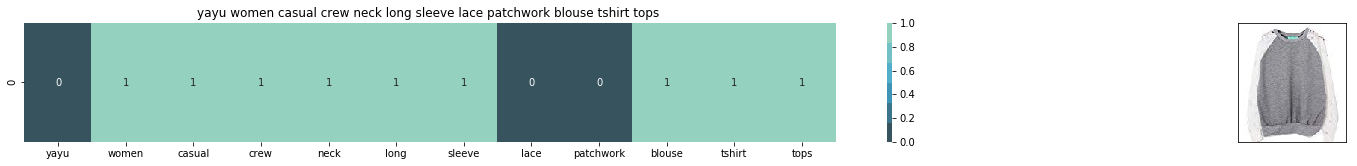

ASIN : B075B5ZCBB
Brand: Yayun
Title: yayu women casual crew neck long sleeve lace patchwork blouse tshirt tops 
Euclidean similarity with the query image : 2.449489742783178


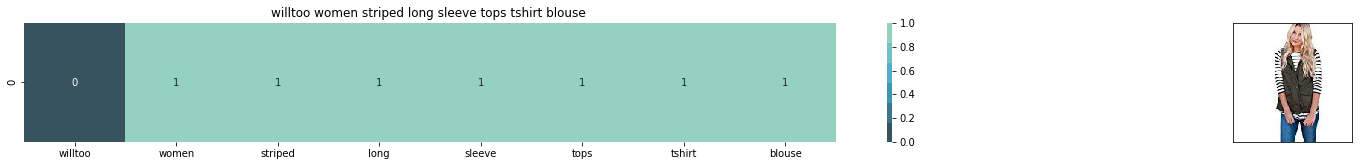

ASIN : B01LYLK0E8
Brand: WILLTOO
Title: willtoo women striped long sleeve tops tshirt blouse 
Euclidean similarity with the query image : 2.449489742783178


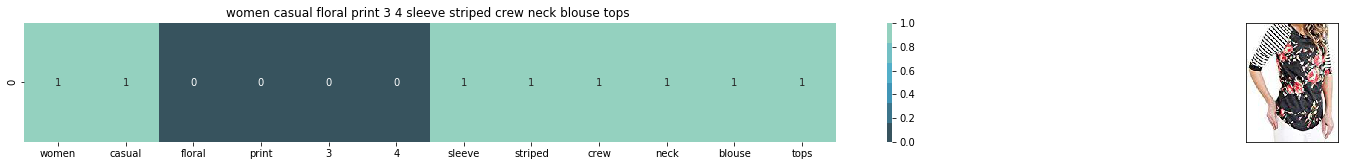

ASIN : B0756FVV5D
Brand: Faithtur
Title: women casual floral print 3 4 sleeve striped crew neck blouse tops 
Euclidean similarity with the query image : 2.449489742783178


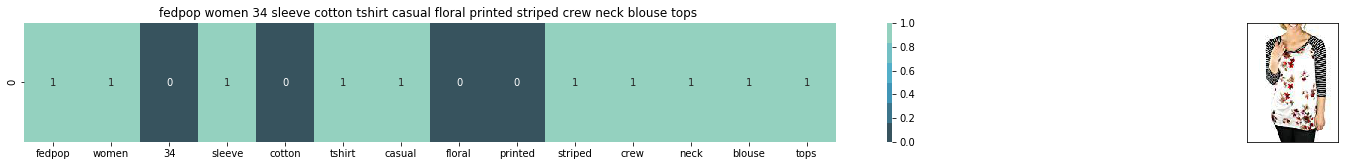

ASIN : B073XZXZBF
Brand: Fedpop
Title: fedpop women 34 sleeve cotton tshirt casual floral printed striped crew neck blouse tops 
Euclidean similarity with the query image : 2.449489742783178


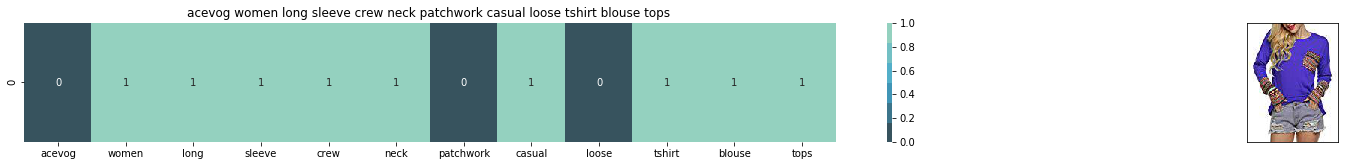

ASIN : B01BINF2X2
Brand: ACEVOG
Title: acevog women long sleeve crew neck patchwork casual loose tshirt blouse tops 
Euclidean similarity with the query image : 2.449489742783178


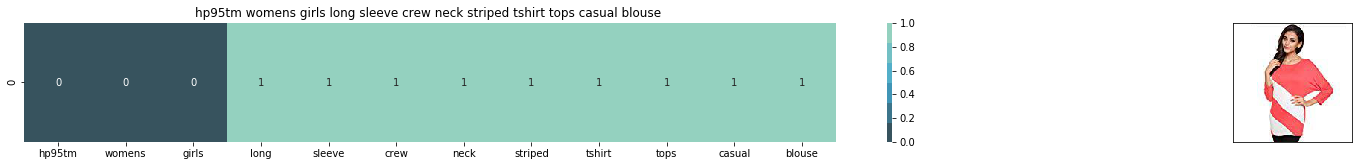

ASIN : B017LLJUUG
Brand: HP95(TM)
Title: hp95tm womens girls long sleeve crew neck striped tshirt tops casual blouse 
Euclidean similarity with the query image : 2.449489742783178


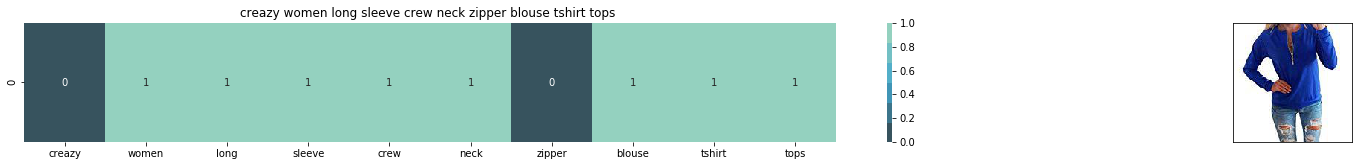

ASIN : B017N5FCQ6
Brand: Creazydog
Title: creazy women long sleeve crew neck zipper blouse tshirt tops 
Euclidean similarity with the query image : 2.449489742783178


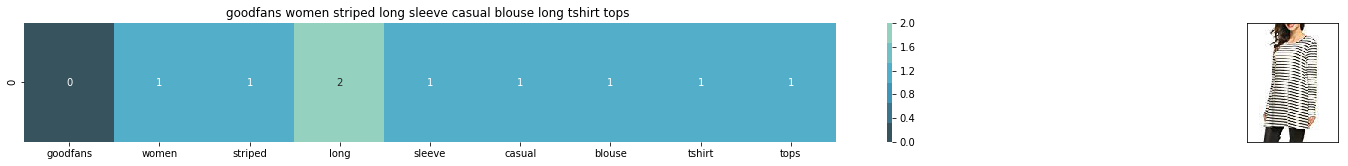

ASIN : B073R637WD
Brand: Goodfans
Title: goodfans women striped long sleeve casual blouse long tshirt tops 
Euclidean similarity with the query image : 2.449489742783178


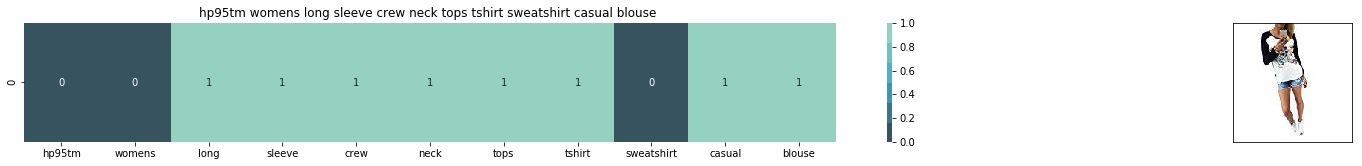

ASIN : B01837ACY0
Brand: HP95(TM)
Title: hp95tm womens long sleeve crew neck tops tshirt sweatshirt casual blouse 
Euclidean similarity with the query image : 2.6457513110645907


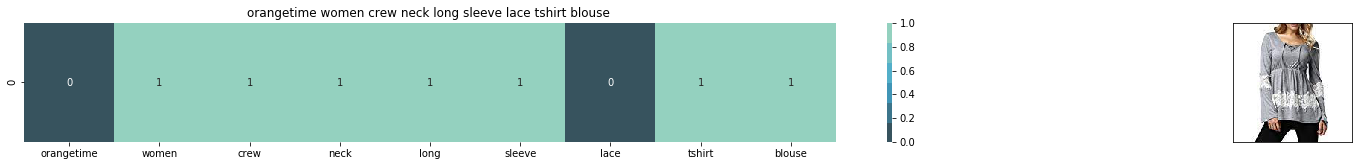

ASIN : B01MZ5DQBJ
Brand: Orangetime
Title: orangetime women crew neck long sleeve lace tshirt blouse 
Euclidean similarity with the query image : 2.6457513110645907


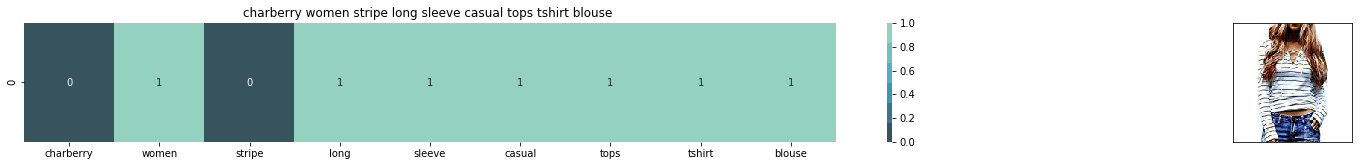

ASIN : B06Y1F19F4
Brand: Charberry
Title: charberry women stripe long sleeve casual tops tshirt blouse 
Euclidean similarity with the query image : 2.6457513110645907


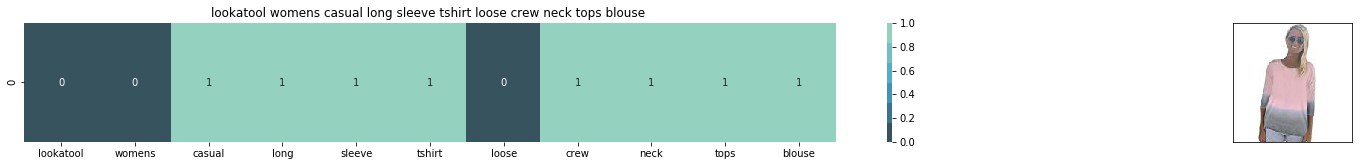

ASIN : B071L7Y3PP
Brand: Lookatool
Title: lookatool womens casual long sleeve tshirt loose crew neck tops blouse 
Euclidean similarity with the query image : 2.6457513110645907


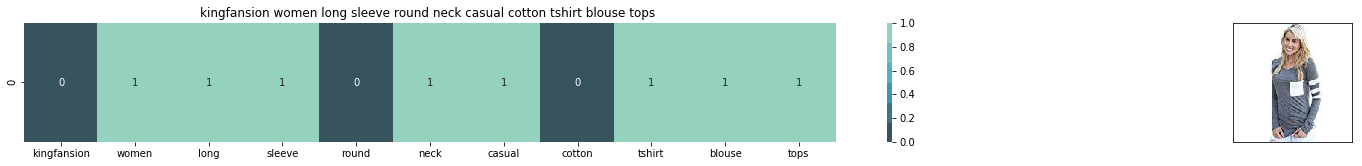

ASIN : B016HJJ0K8
Brand: kingfansion
Title: kingfansion women long sleeve round neck casual cotton tshirt blouse tops 
Euclidean similarity with the query image : 2.6457513110645907


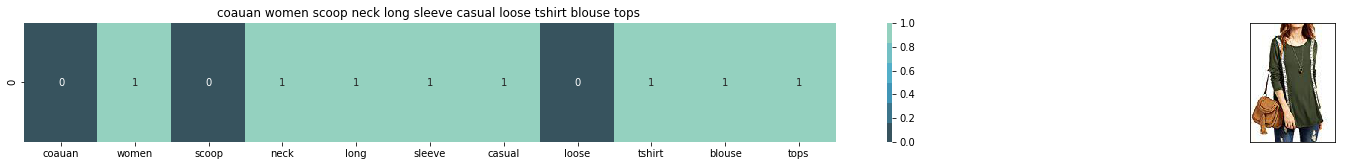

ASIN : B01N7FD0LZ
Brand: Coauan
Title: coauan women scoop neck long sleeve casual loose tshirt blouse tops 
Euclidean similarity with the query image : 2.6457513110645907


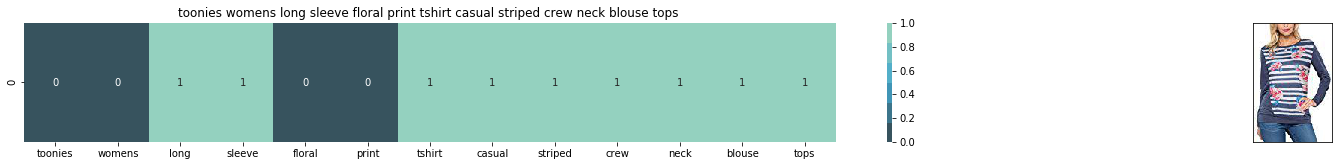

ASIN : B075B4TG8H
Brand: TOONIES
Title: toonies womens long sleeve floral print tshirt casual striped crew neck blouse tops 
Euclidean similarity with the query image : 2.6457513110645907


In [142]:
def bag_of_words_model(doc_id, num_results):
    
    pairwise_dist = pairwise_distances(title_features, title_features[doc_id])
    indices = np.argsort(pairwise_dist.flatten())[0: num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0: num_results]
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], df_indices[i], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)

bag_of_words_model(97855, 20) 

### [B] TF-IDF based product similarity

In [143]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

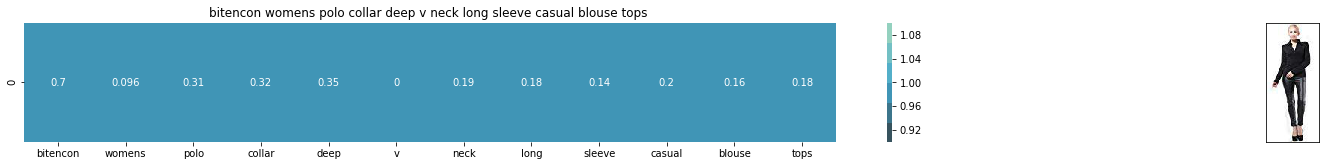

ASIN : B018UJCPTQ
BRAND : Bi.tencon
Eucliden distance from the given image : 0.0


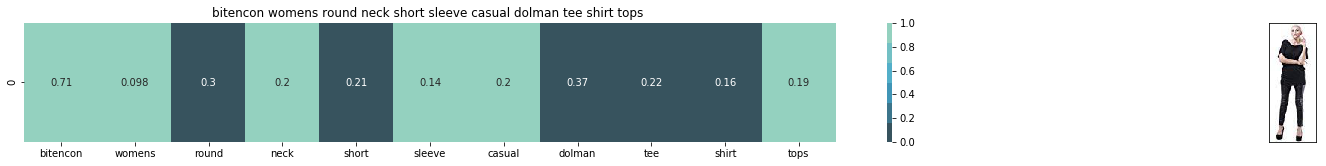

ASIN : B018UJCEL0
BRAND : Bi.tencon
Eucliden distance from the given image : 0.8520562259807999


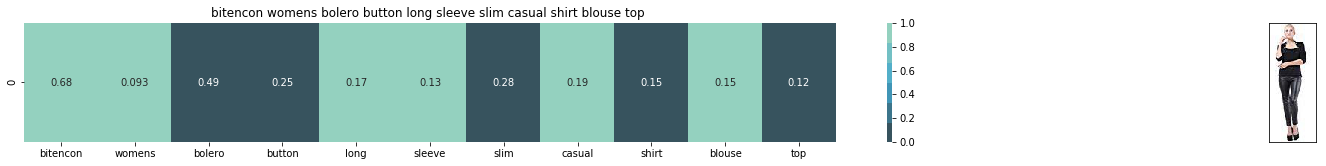

ASIN : B018UJD1EE
BRAND : Bi.tencon
Eucliden distance from the given image : 0.9031518503275435


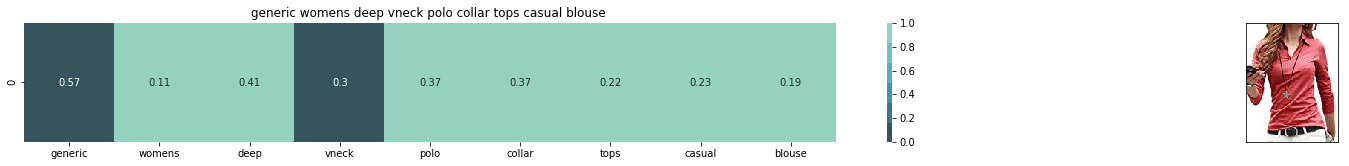

ASIN : B01M7P1YI0
BRAND : Generic
Eucliden distance from the given image : 0.99776705138702


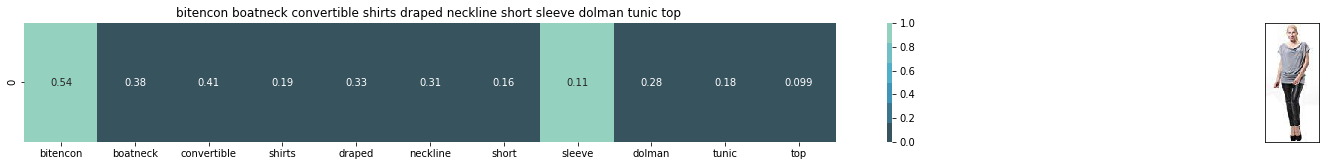

ASIN : B018UK6622
BRAND : Unknown
Eucliden distance from the given image : 1.1050924075447217


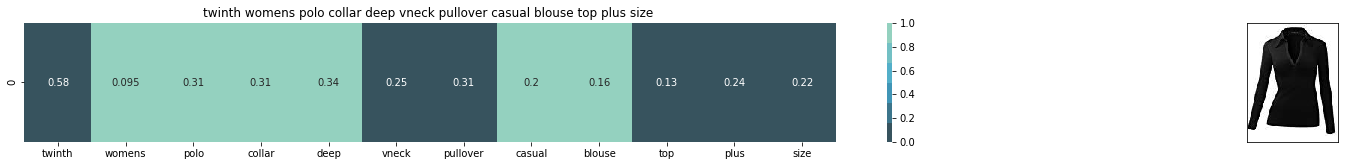

ASIN : B01MTLLE9E
BRAND : TWINTH
Eucliden distance from the given image : 1.1072025132163799


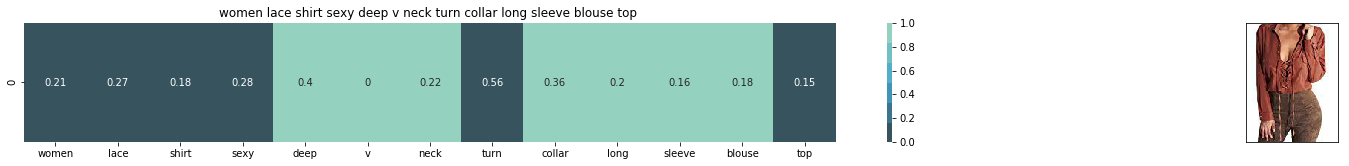

ASIN : B074H2DXPJ
BRAND : Jingjing1
Eucliden distance from the given image : 1.1120732603799273


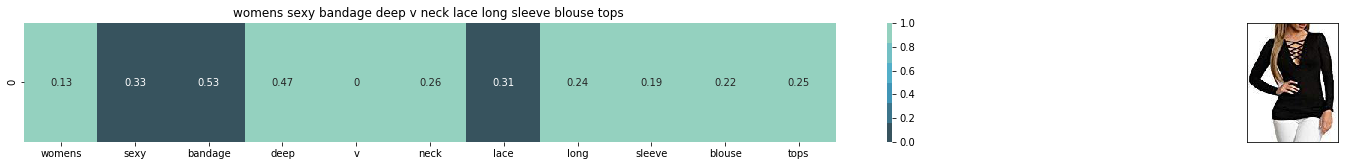

ASIN : B01M03YCXO
BRAND : eshion
Eucliden distance from the given image : 1.1191289107074716


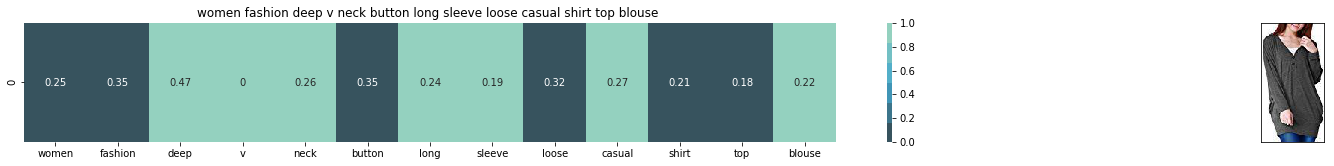

ASIN : B01N19RSOS
BRAND : Kearia
Eucliden distance from the given image : 1.120008139959284


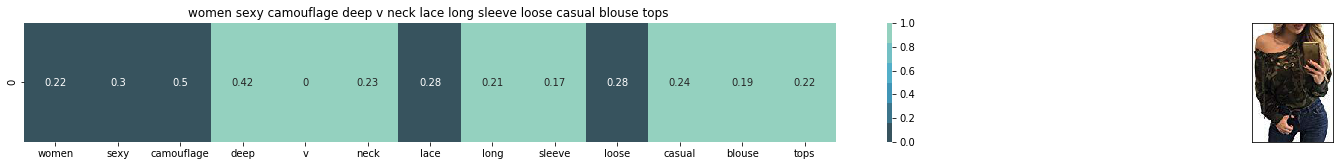

ASIN : B01MR7ZPKW
BRAND : Kearia
Eucliden distance from the given image : 1.1213441976844234


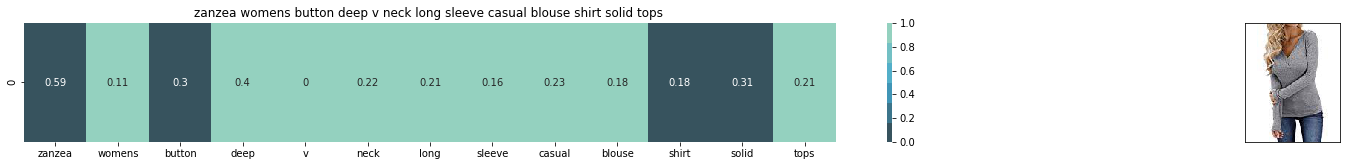

ASIN : B074L1Q3WT
BRAND : ZANZEA
Eucliden distance from the given image : 1.1252171219116753


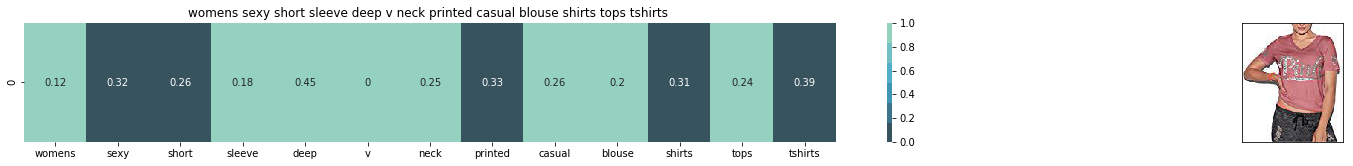

ASIN : B07431KGSP
BRAND : Hotheart
Eucliden distance from the given image : 1.1256160808162932


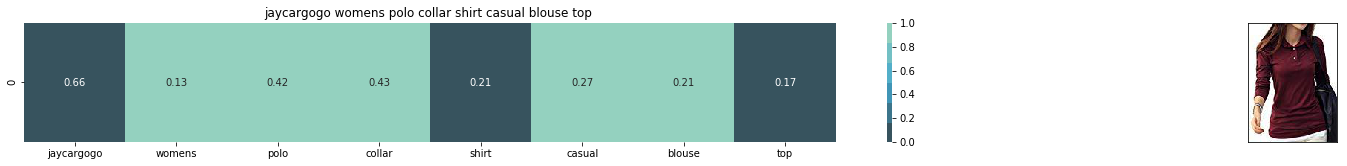

ASIN : B01MECLP23
BRAND : Jaycargogo
Eucliden distance from the given image : 1.125692902656569


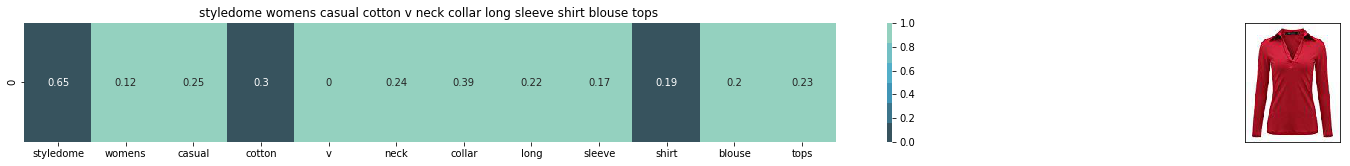

ASIN : B01FM5A20A
BRAND : StyleDome
Eucliden distance from the given image : 1.1284326905884108


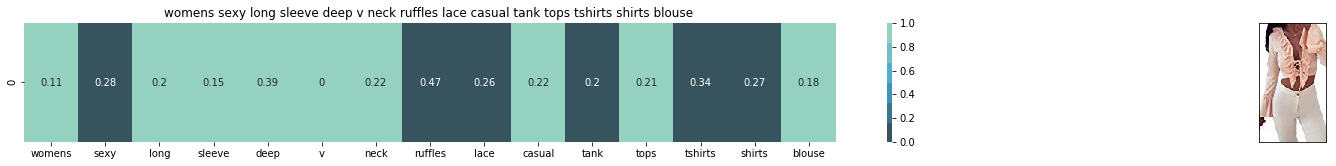

ASIN : B074358N5X
BRAND : Hotheart
Eucliden distance from the given image : 1.1353093155114993


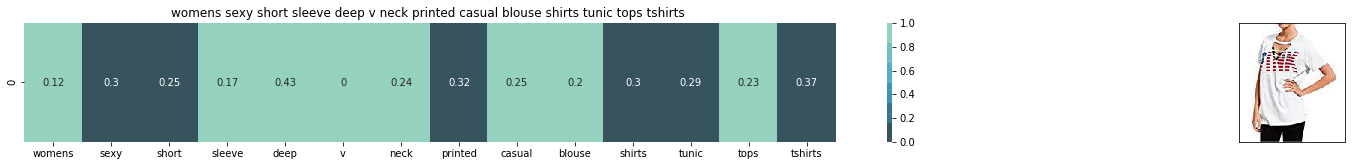

ASIN : B07436WX4F
BRAND : Hotheart
Eucliden distance from the given image : 1.139083150056584


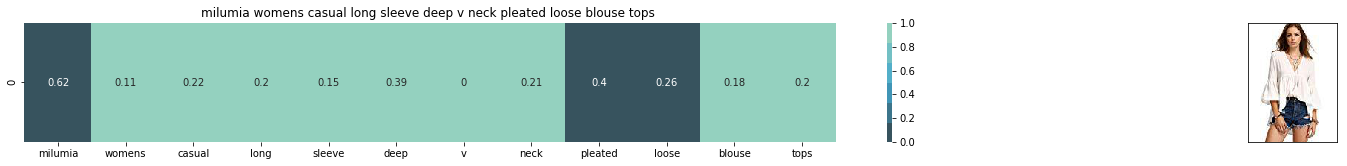

ASIN : B01I3BMTAQ
BRAND : Milumia
Eucliden distance from the given image : 1.1398354840600922


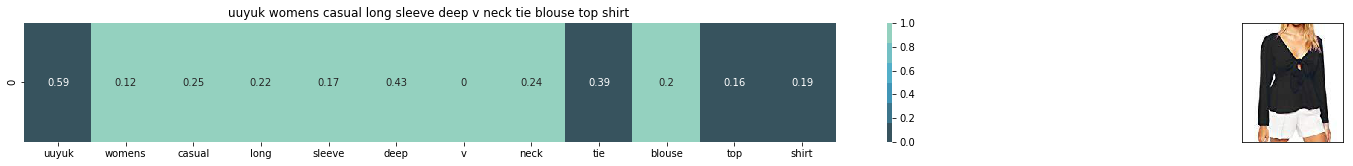

ASIN : B074X4BVK4
BRAND : UUYUK
Eucliden distance from the given image : 1.1402226569207181


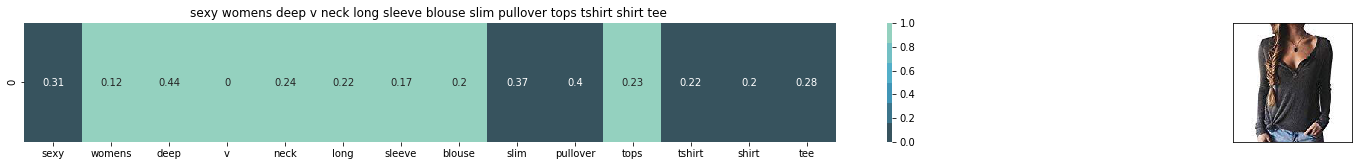

ASIN : B016UMLKIW
BRAND : Innovateyfm
Eucliden distance from the given image : 1.1408498745837945


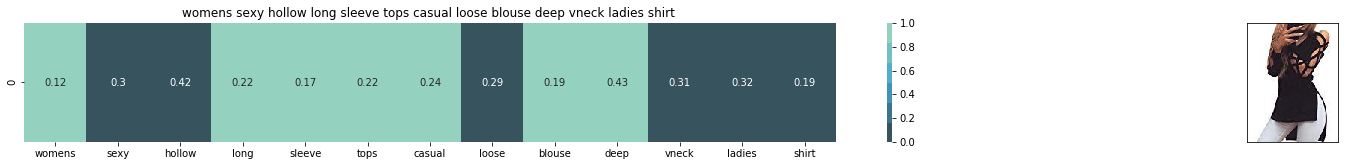

ASIN : B06XKGMNSQ
BRAND : Lantch
Eucliden distance from the given image : 1.1479788182462463


In [146]:
def tfidf_model(doc_id, num_results):

    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], df_indices[i], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*60)

tfidf_model(125660, 20)

### [C] IDF based product similarity

In [27]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

In [29]:
def n_containing(word):
    #return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    #idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [30]:
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        #replace the count values of word i in document j with  idf_value of word i 
        #idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val

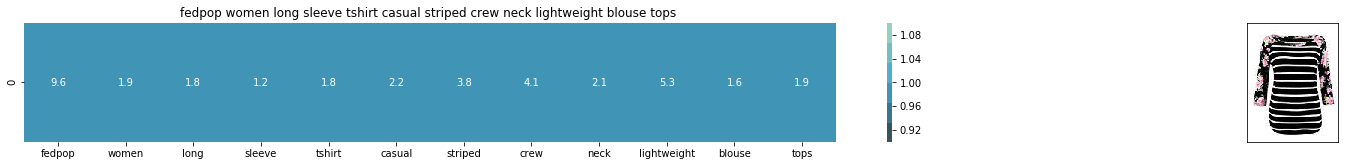

ASIN : B073XZSZXR
Brand : Fedpop
euclidean distance from the given image : 0.0


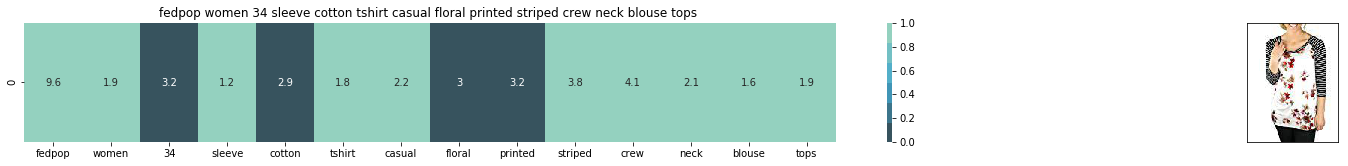

ASIN : B073XZXZBF
Brand : Fedpop
euclidean distance from the given image : 8.357535786167414


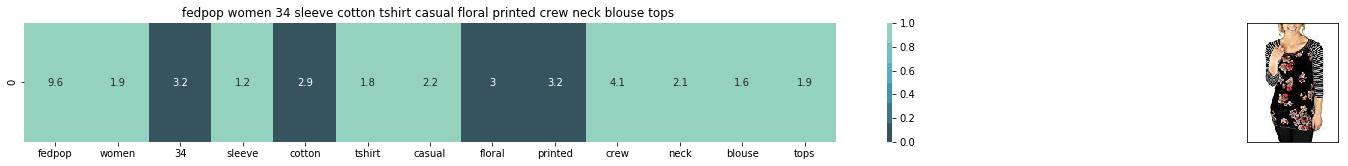

ASIN : B073Y14V88
Brand : Fedpop
euclidean distance from the given image : 9.16091048268534


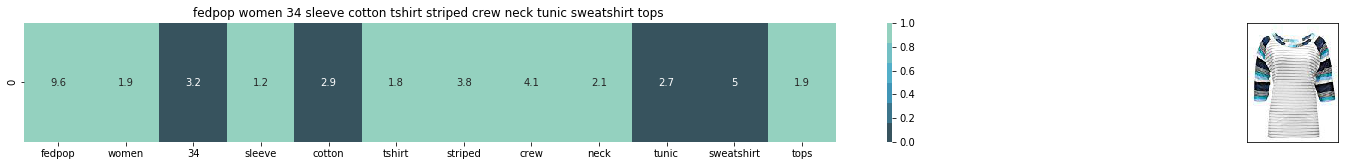

ASIN : B073XNBJGC
Brand : Fedpop
euclidean distance from the given image : 9.486284166308838


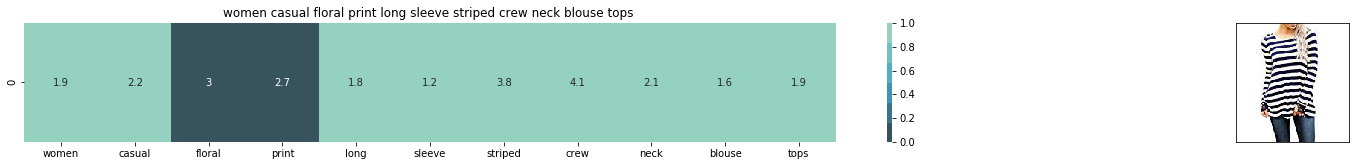

ASIN : B0757MFLW4
Brand : FAROOT
euclidean distance from the given image : 11.872269871947632


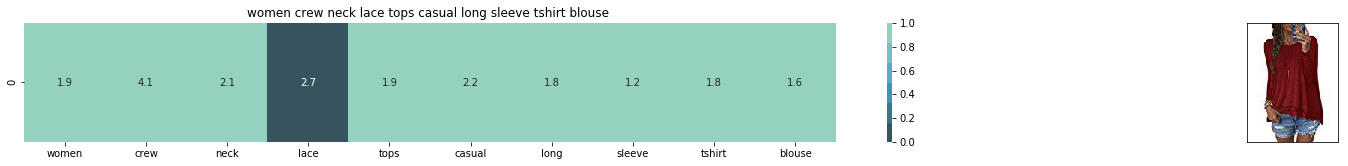

ASIN : B01L8SF5SY
Brand : Yidarton
euclidean distance from the given image : 11.945611949012516


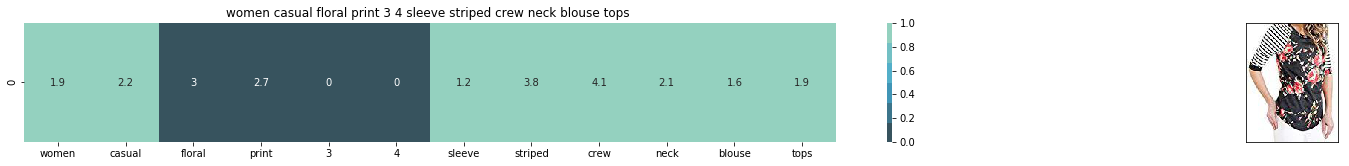

ASIN : B0756FVV5D
Brand : Faithtur
euclidean distance from the given image : 12.014430932410075


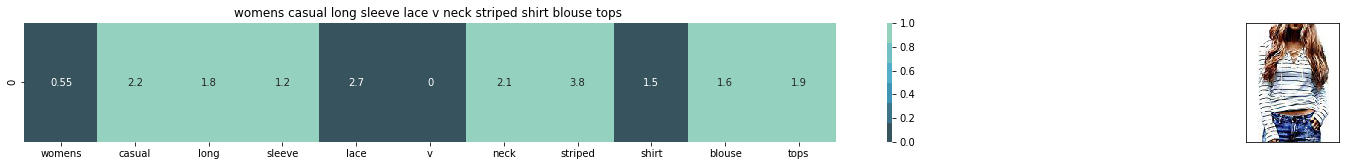

ASIN : B0749H9BJL
Brand : OURS
euclidean distance from the given image : 12.457624542314084


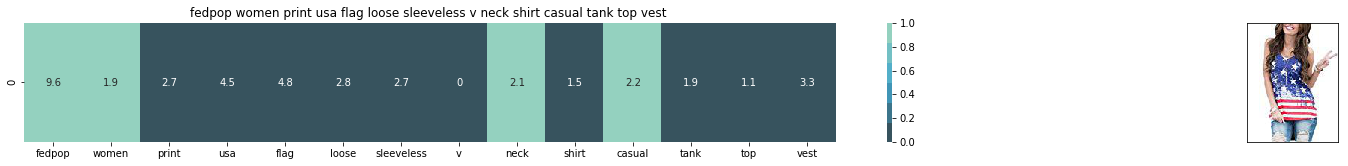

ASIN : B0725RCQKM
Brand : Fedpop
euclidean distance from the given image : 12.545193291650852


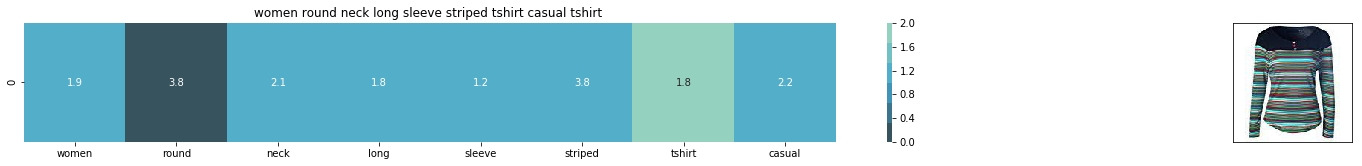

ASIN : B074M7M7C1
Brand : SG
euclidean distance from the given image : 12.601086547721312


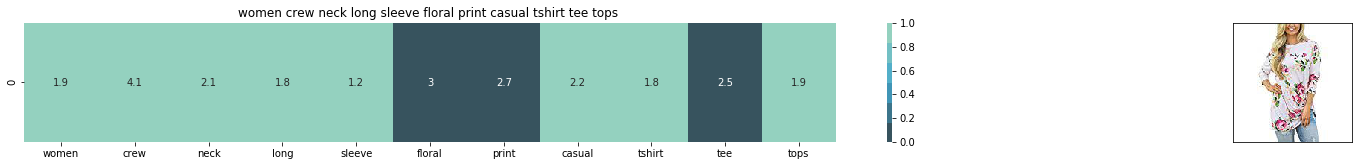

ASIN : B0756ZXBWF
Brand : YF
euclidean distance from the given image : 12.664966675357967


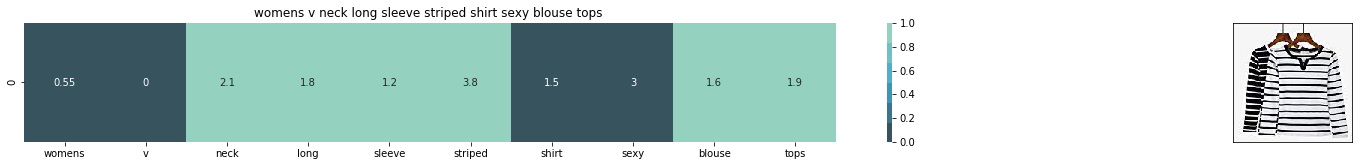

ASIN : B06XNQDN4T
Brand : LemonGirl
euclidean distance from the given image : 12.704682817482228


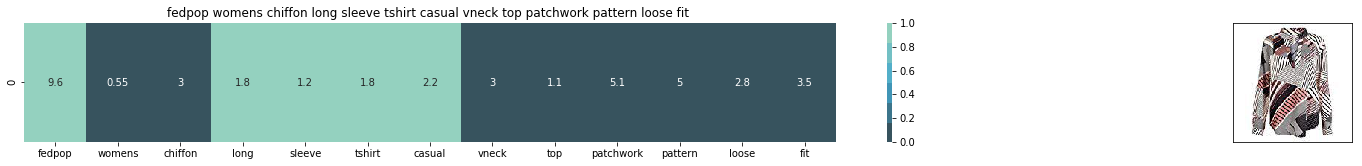

ASIN : B074M5YWG1
Brand : Fedpop
euclidean distance from the given image : 12.836155828394864


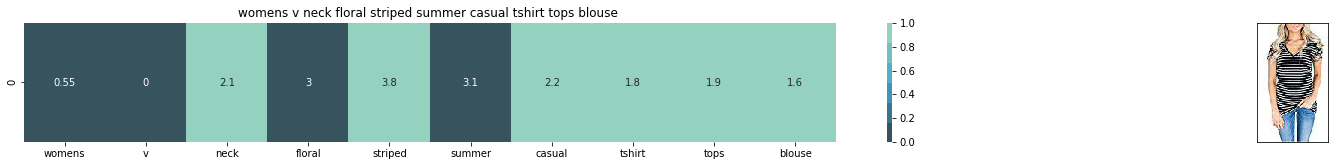

ASIN : B072M6QFV4
Brand : BiggerStore
euclidean distance from the given image : 12.862498037960128


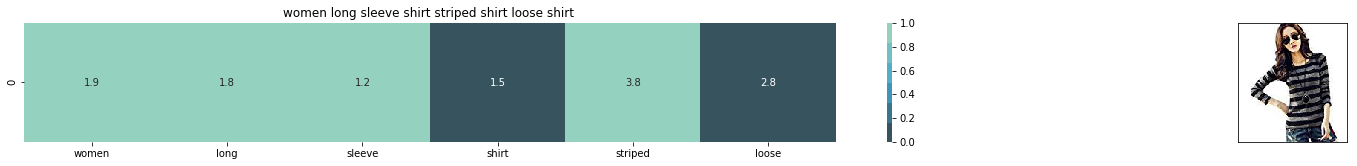

ASIN : B01KQ8DKI4
Brand : HP-LEISURE
euclidean distance from the given image : 12.918164690648451


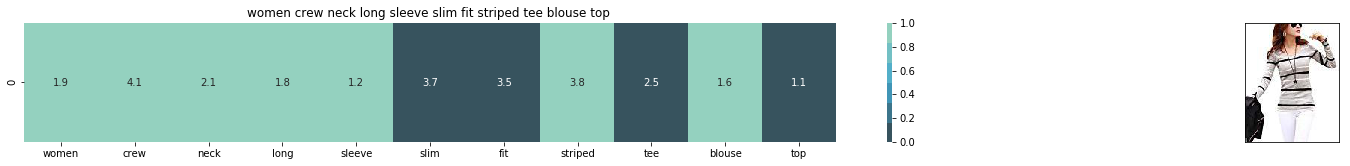

ASIN : B01M240R3Z
Brand : Fairviewer
euclidean distance from the given image : 12.922832329794883


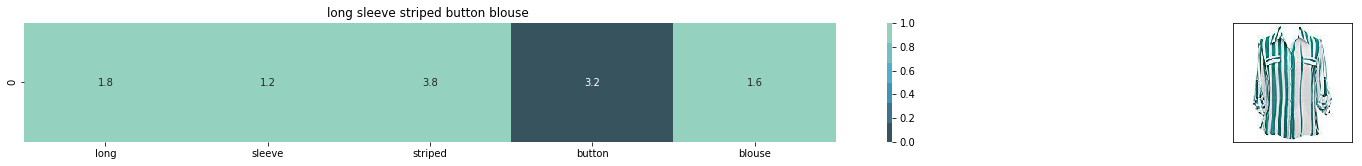

ASIN : B00UWX1MRA
Brand : Luxury Divas
euclidean distance from the given image : 12.97269357091572


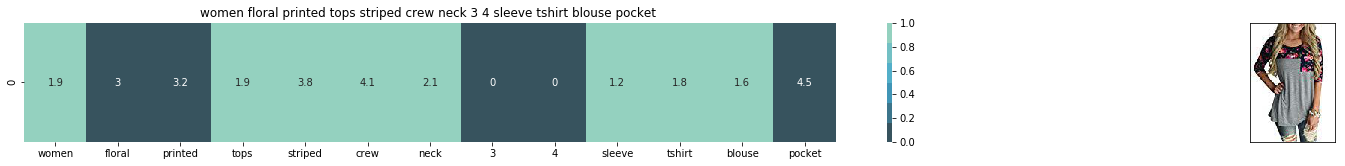

ASIN : B0748NHP5N
Brand : ANDYICEE
euclidean distance from the given image : 13.007784606602836


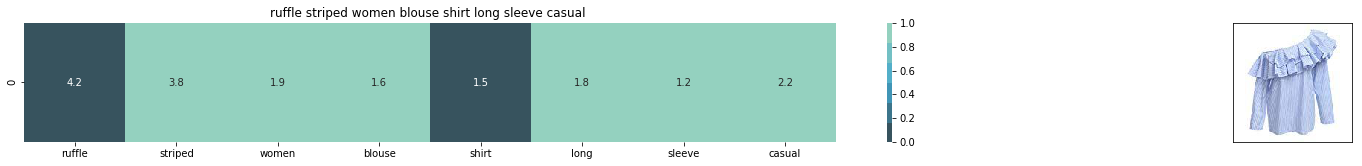

ASIN : B06XQD9XBS
Brand : Dresswell
euclidean distance from the given image : 13.02480106413292


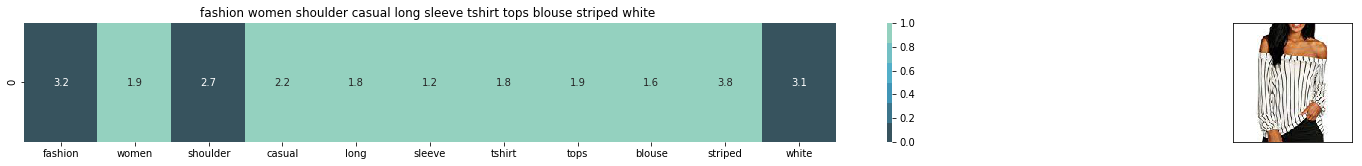

ASIN : B01JYS107K
Brand : Paixpays
euclidean distance from the given image : 13.025172197816287


In [151]:
def idf_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], df_indices[i], 'idf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*60)
        
idf_model(97855, 20)

## 7. Text Semantic based product similarity

In [25]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

model = KeyedVectors.load_word2vec_format('../GoogleNews-vectors-negative300.bin', binary=True)
vocab = model.wv.vocab.keys()

def get_word_vec(sentence, doc_id, m_name):
    vec = []
    
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            vec.append(np.zeros(shape=(300,)))
    
    return  np.array(vec)


def get_distance(vec1, vec2):
    final_dist = []
    
    for i in vec1:
        dist = []
        for j in vec2:
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))

    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, indx, doc_id1, doc_id2, model):
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    s2_vec = get_word_vec(sentence2, doc_id2, model)
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1],height_ratios=[2, 1]) 
    fig = plt.figure(figsize= (15, 15))
    
    ax = plt.subplot(gs[0])
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True, cmap=sns.color_palette("Blues"))
    ax.set_xticklabels(sentence2.split())
    ax.set_yticklabels(sentence1.split())
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(indx, ax, fig)
    
    plt.show()

In [154]:
vocab = model.wv.vocab

def build_avg_vec(sentence, num_features, doc_id, m_name):
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
                
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)

    return featureVec

### [A] Average Word2Vec product similarity

In [155]:
doc_id = 0
w2v_title = []

for i in data['title']:
    w2v_title.append(build_avg_vec(i, 300, doc_id, 'avg'))
    doc_id += 1

w2v_title = np.array(w2v_title)

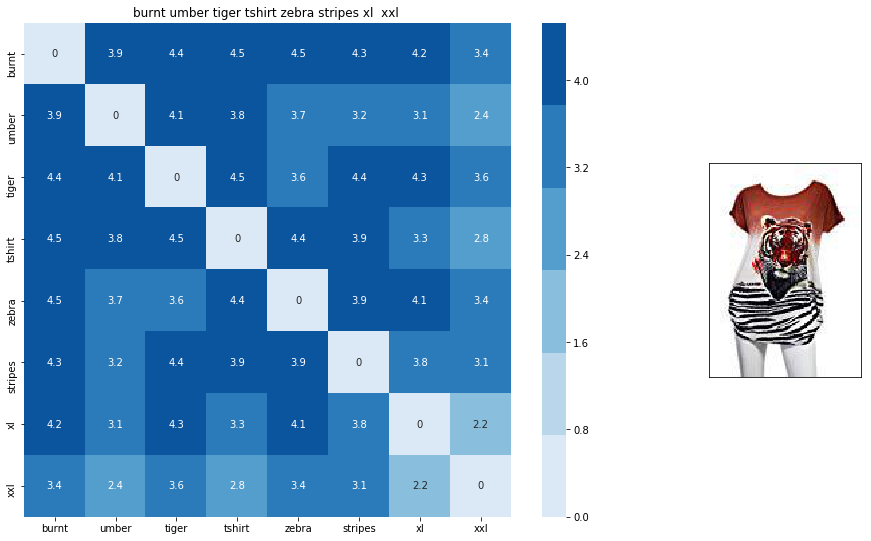

ASIN : B00JXQB5FQ
BRAND : Si Row
euclidean distance from given input image : 0.00069053395


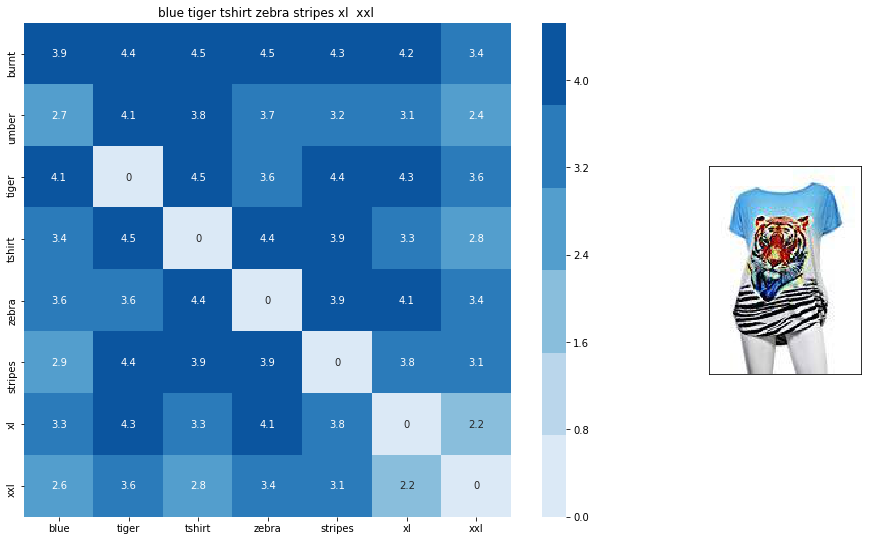

ASIN : B00JXQAKWU
BRAND : Si Row
euclidean distance from given input image : 0.5675141


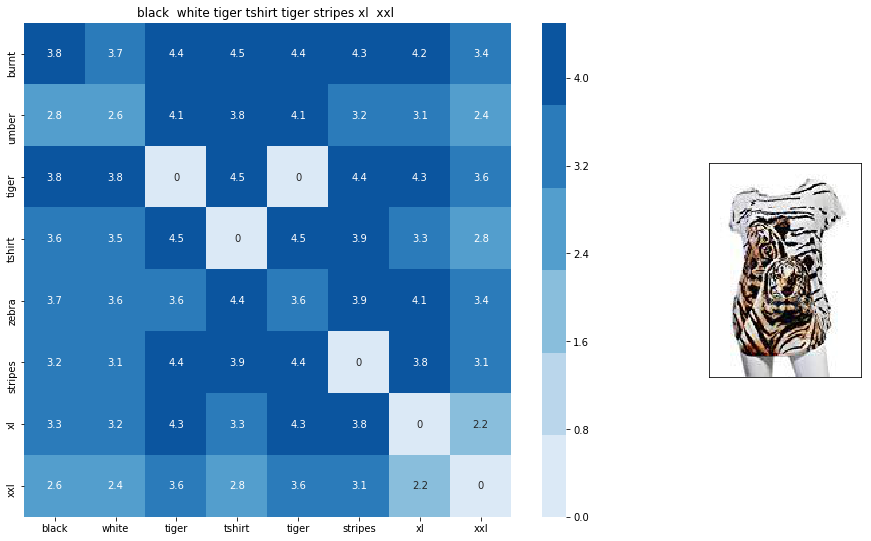

ASIN : B00JXQAC2I
BRAND : Si Row
euclidean distance from given input image : 0.76566297


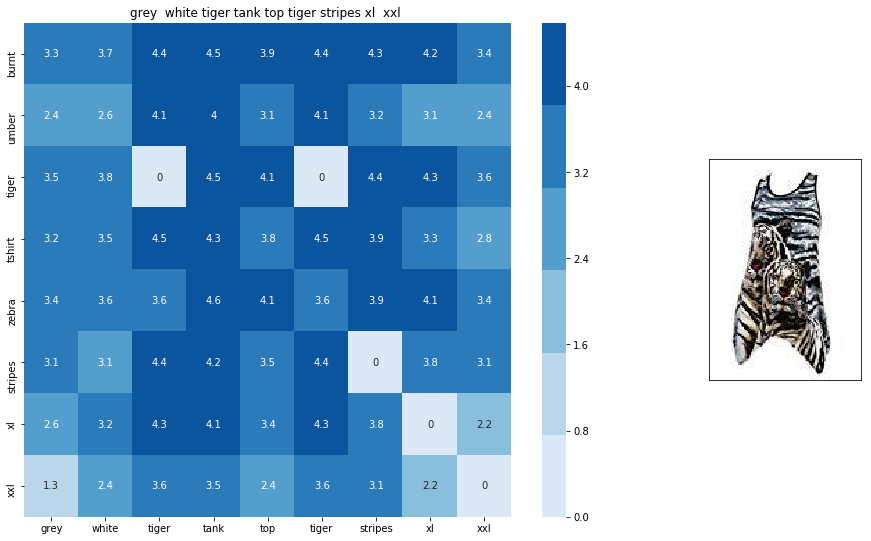

ASIN : B00JXQAFZ2
BRAND : Si Row
euclidean distance from given input image : 0.8928398


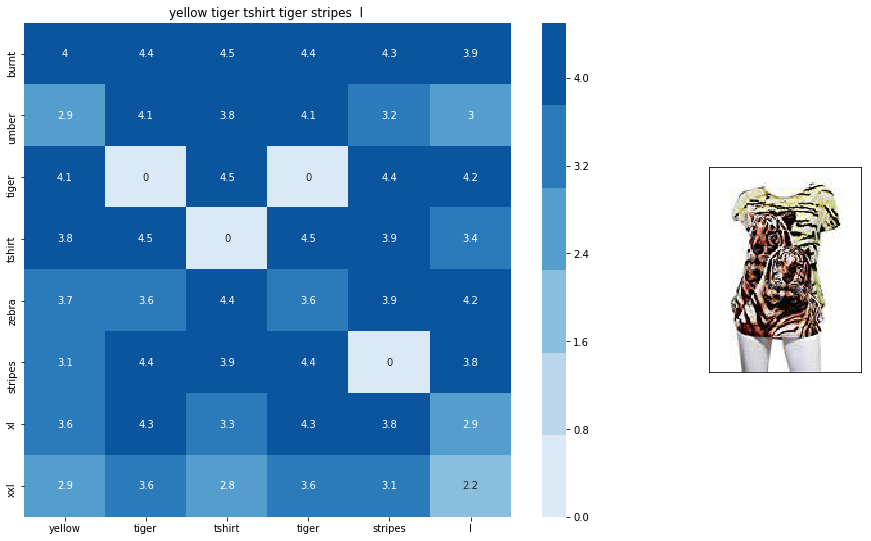

ASIN : B00JXQCUIC
BRAND : Si Row
euclidean distance from given input image : 0.95601267


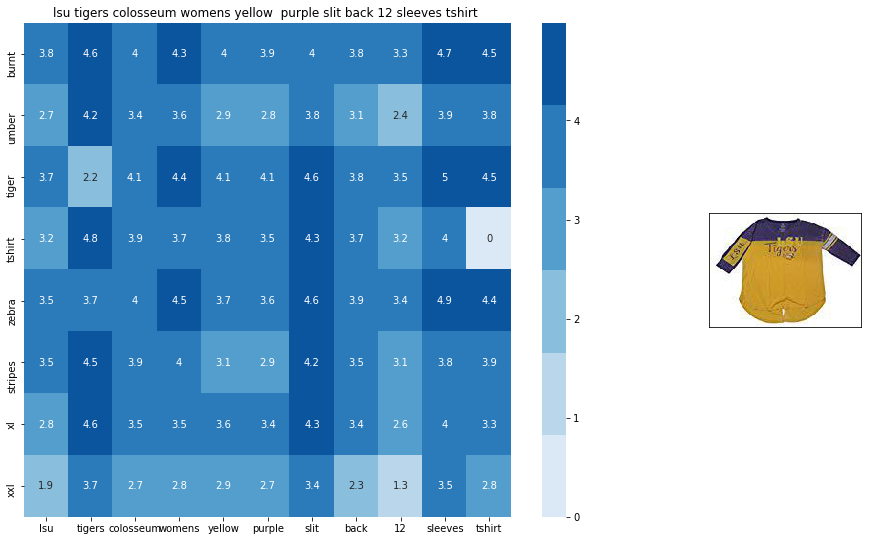

ASIN : B073R5Q8HD
BRAND : Colosseum
euclidean distance from given input image : 1.0229691


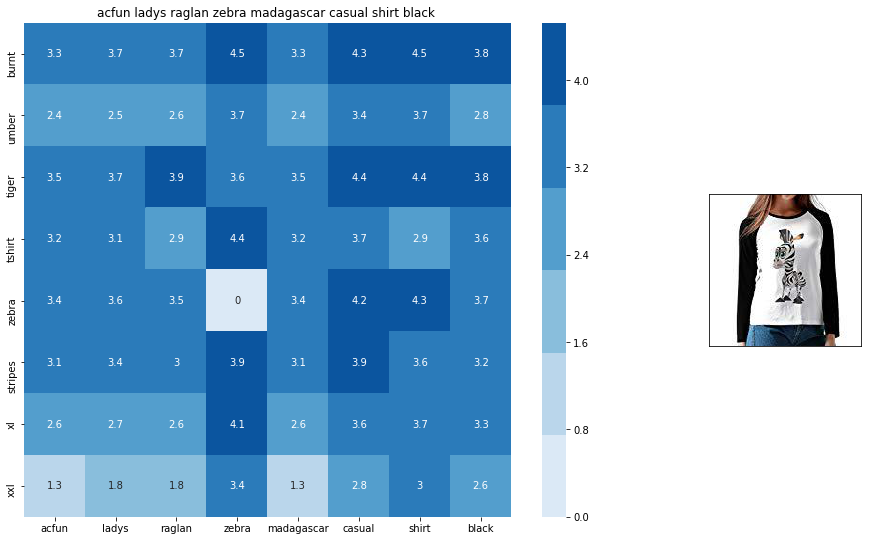

ASIN : B01MAWN1Y7
BRAND : ACFUN
euclidean distance from given input image : 1.0230784


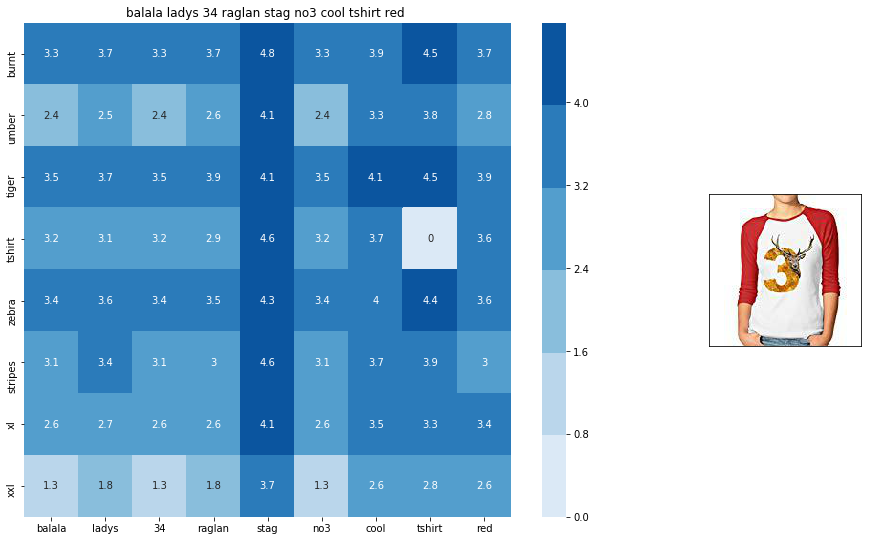

ASIN : B01M7X7P90
BRAND : balala
euclidean distance from given input image : 1.0453961


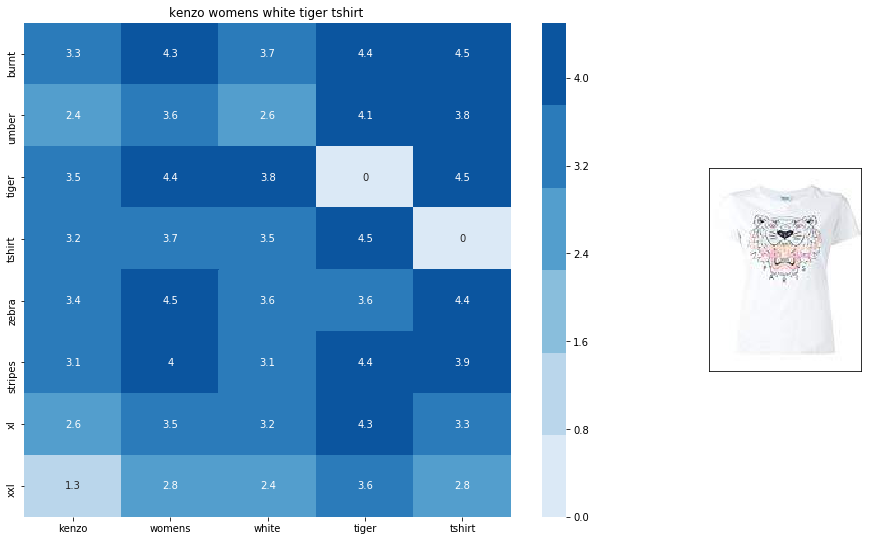

ASIN : B0725YNBG1
BRAND : Kenzo
euclidean distance from given input image : 1.0514722


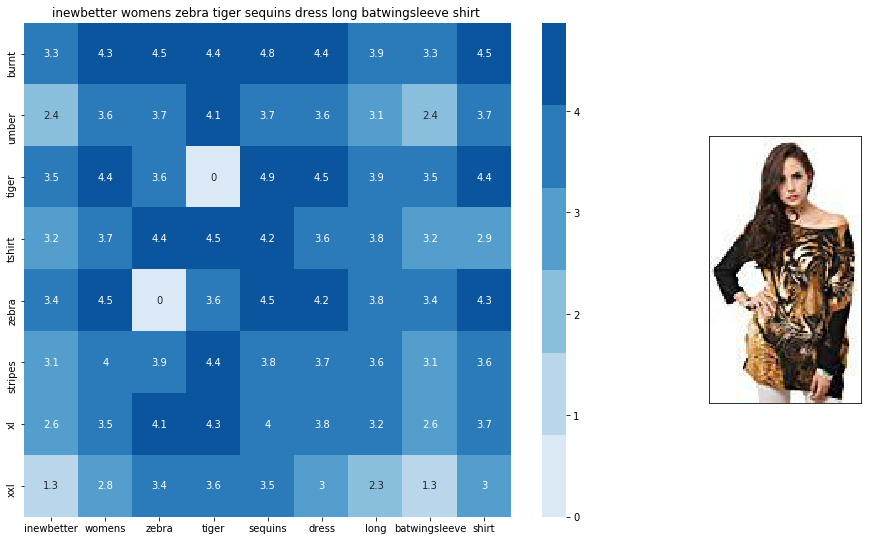

ASIN : B010E86D8K
BRAND : iNewbetter
euclidean distance from given input image : 1.0536854


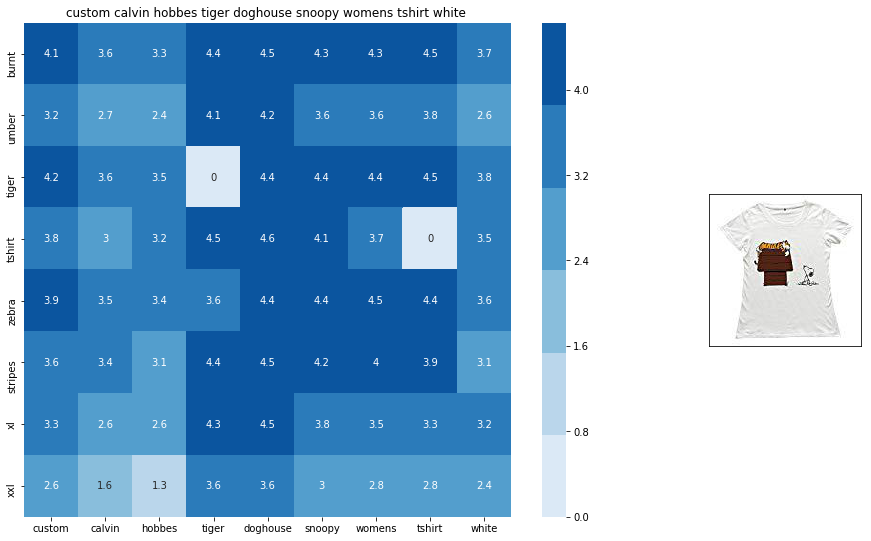

ASIN : B012GK86IE
BRAND : MAM2 Arts
euclidean distance from given input image : 1.0622014


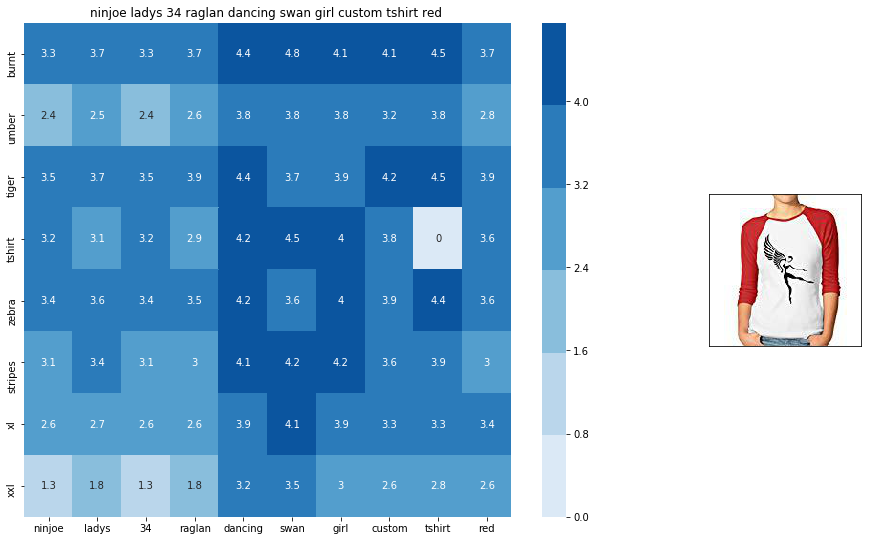

ASIN : B01LHD9QFI
BRAND : NINJOE
euclidean distance from given input image : 1.066438


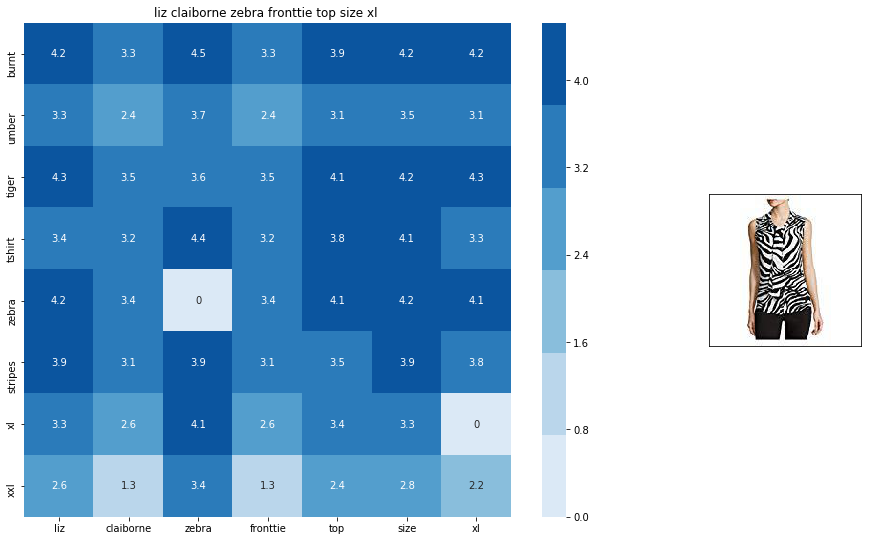

ASIN : B06XBY5QXL
BRAND : Liz Claiborne
euclidean distance from given input image : 1.0669324


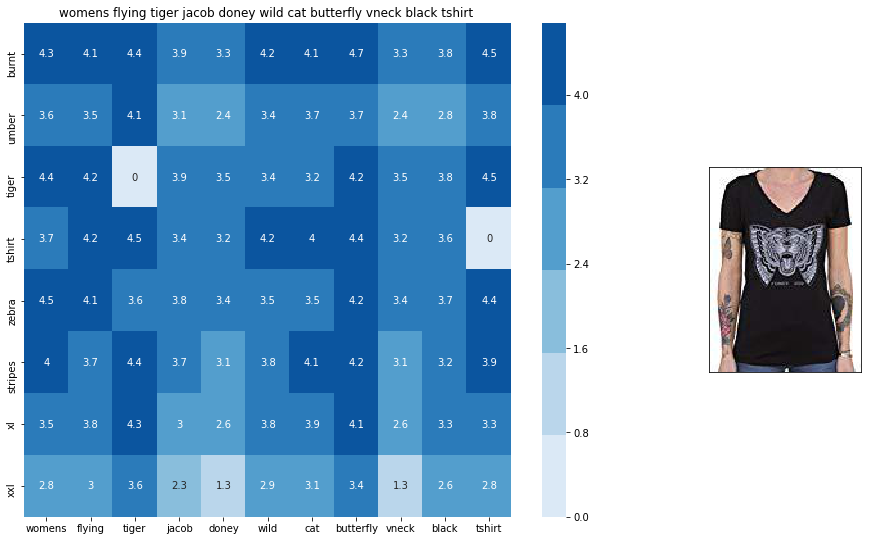

ASIN : B01NAWC7DW
BRAND : Black Market Art
euclidean distance from given input image : 1.0674566


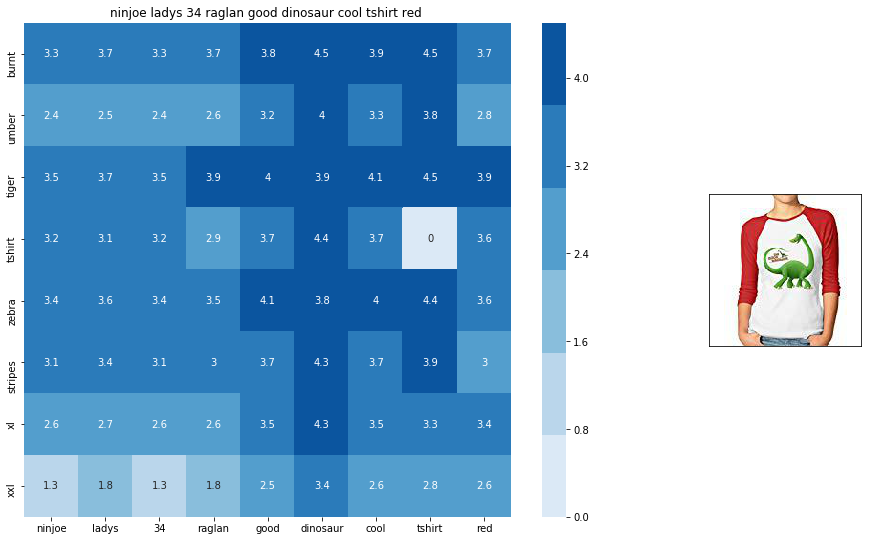

ASIN : B01K7M414G
BRAND : NINJOE
euclidean distance from given input image : 1.0701729


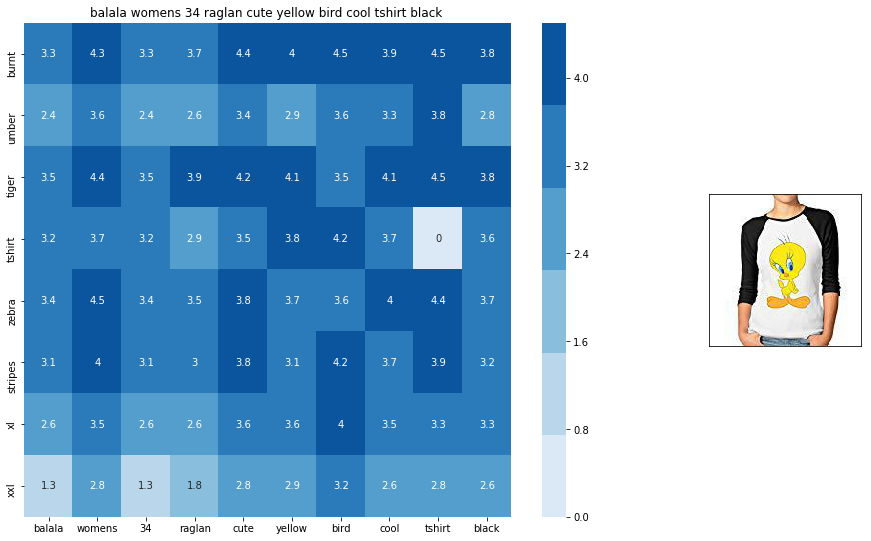

ASIN : B01M8PWOLJ
BRAND : balala
euclidean distance from given input image : 1.0721796


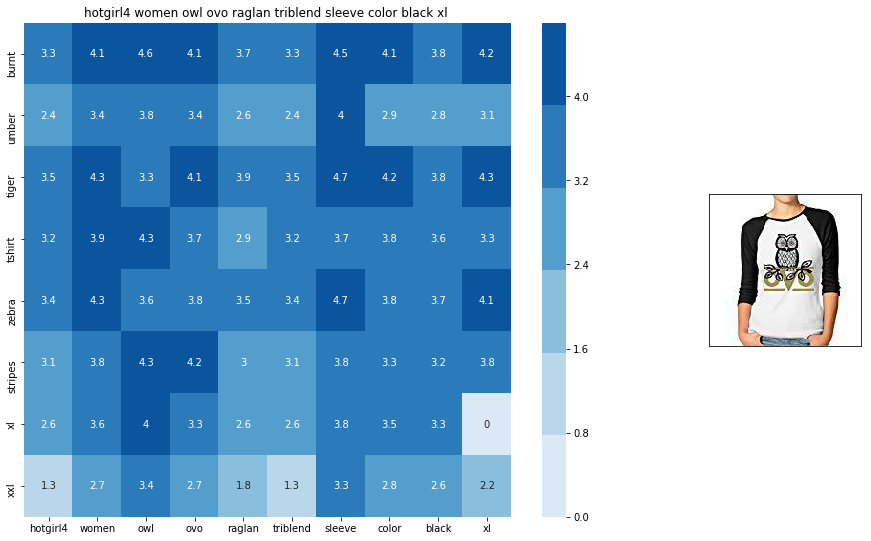

ASIN : B01L8L73M2
BRAND : Hotgirl4 Raglan Design
euclidean distance from given input image : 1.0731405


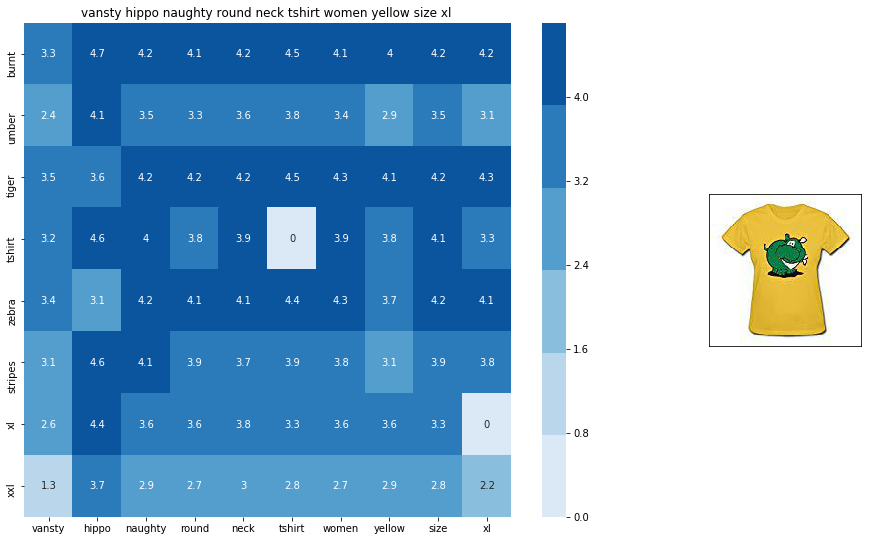

ASIN : B01EJS5H06
BRAND : Vansty
euclidean distance from given input image : 1.075719


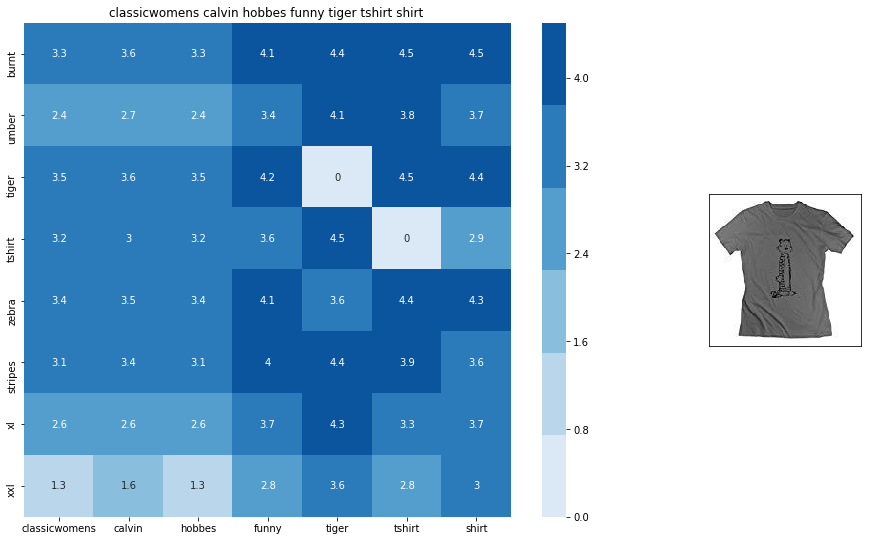

ASIN : B01LBF0BW4
BRAND : ClassicUSAt-101
euclidean distance from given input image : 1.0784446


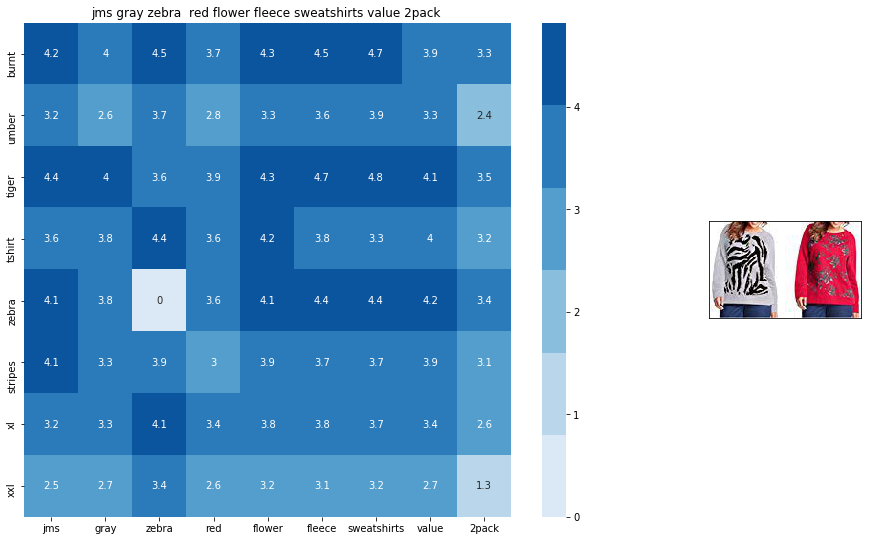

ASIN : B01KU821SA
BRAND : Just My Size
euclidean distance from given input image : 1.0827295


In [173]:
def avg_w2v_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(w2v_title, w2v_title[doc_id].reshape(1,-1))
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], df_indices[i], indices[0], indices[i], 'avg')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from given input image :', pdists[i])
        print('='*60)

        
avg_w2v_model(118177, 20)

### [B] IDF weighted Word2Vec for product similarity

In [174]:
doc_id = 0
w2v_title_weight = []

for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1

w2v_title_weight = np.array(w2v_title_weight)

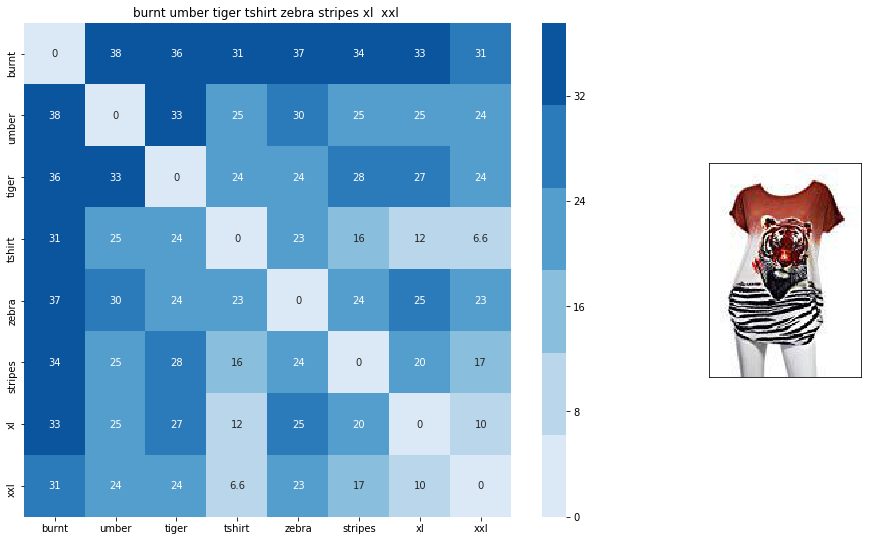

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.00390625


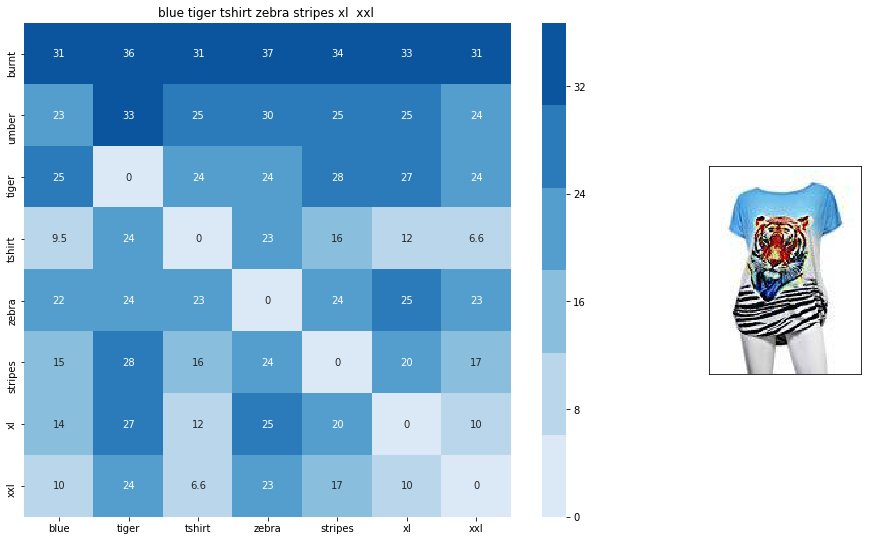

ASIN : B00JXQAKWU
Brand : Si Row
euclidean distance from input : 4.799974


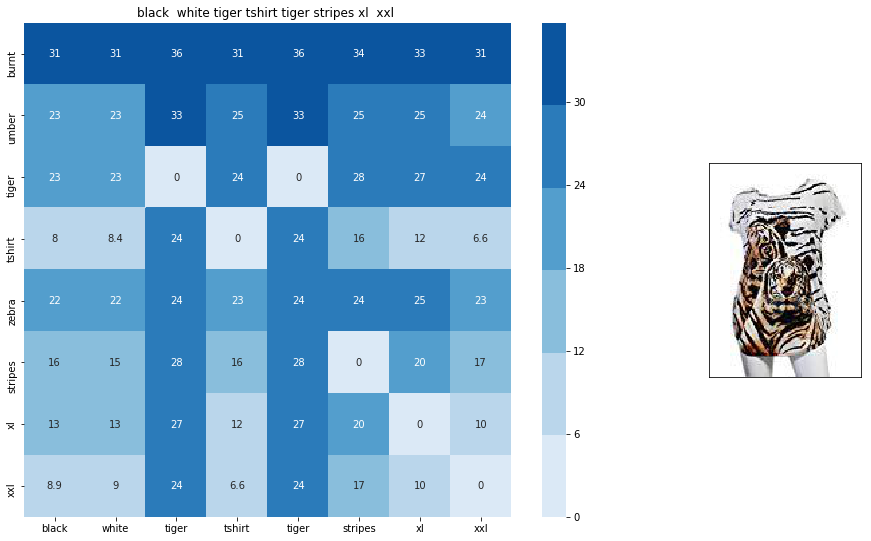

ASIN : B00JXQAC2I
Brand : Si Row
euclidean distance from input : 5.7684608


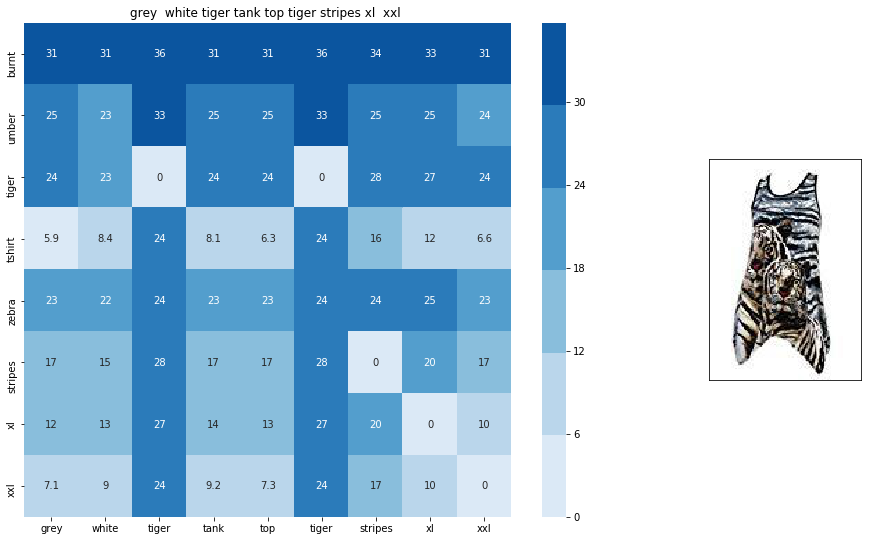

ASIN : B00JXQAFZ2
Brand : Si Row
euclidean distance from input : 6.039663


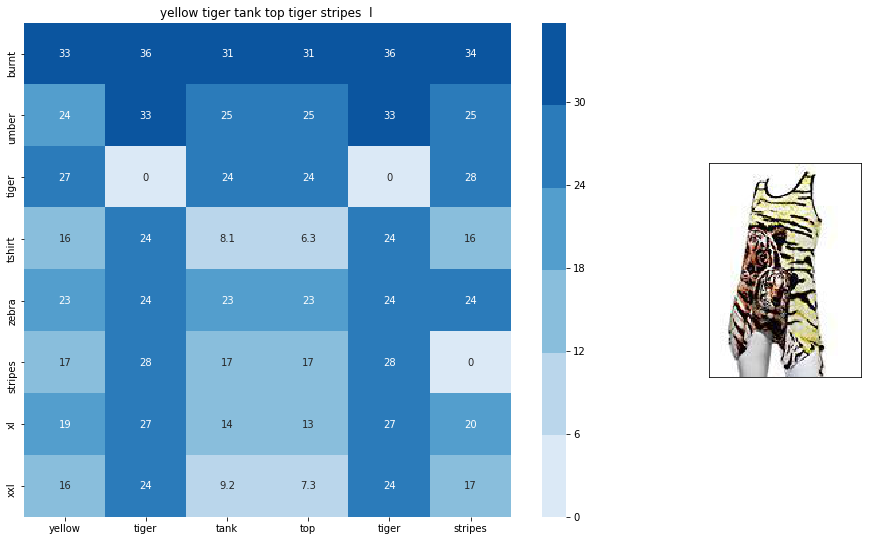

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from input : 6.7013383


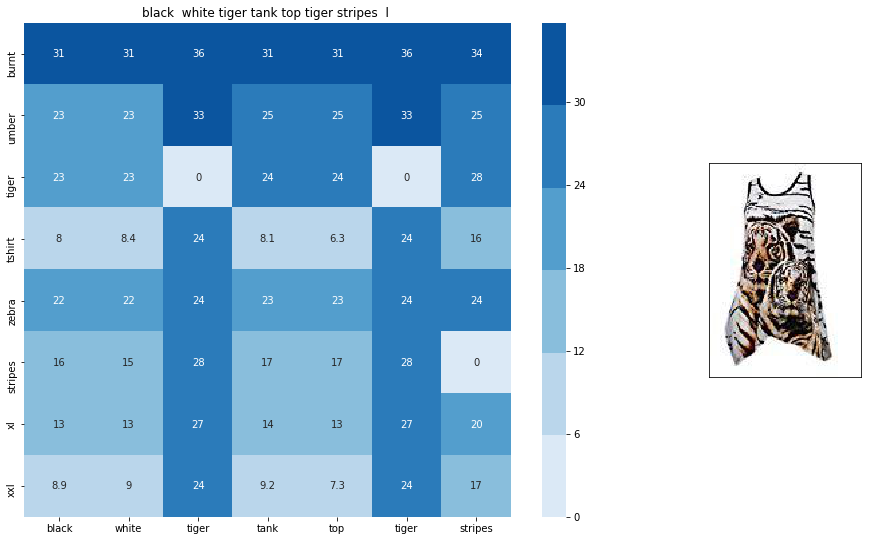

ASIN : B00JXQAO94
Brand : Si Row
euclidean distance from input : 6.7035365


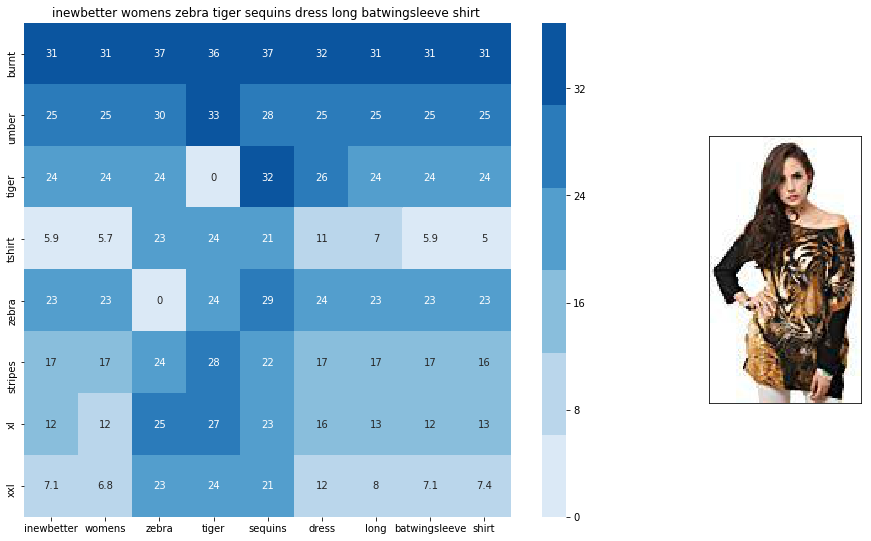

ASIN : B010E86D8K
Brand : iNewbetter
euclidean distance from input : 6.749575


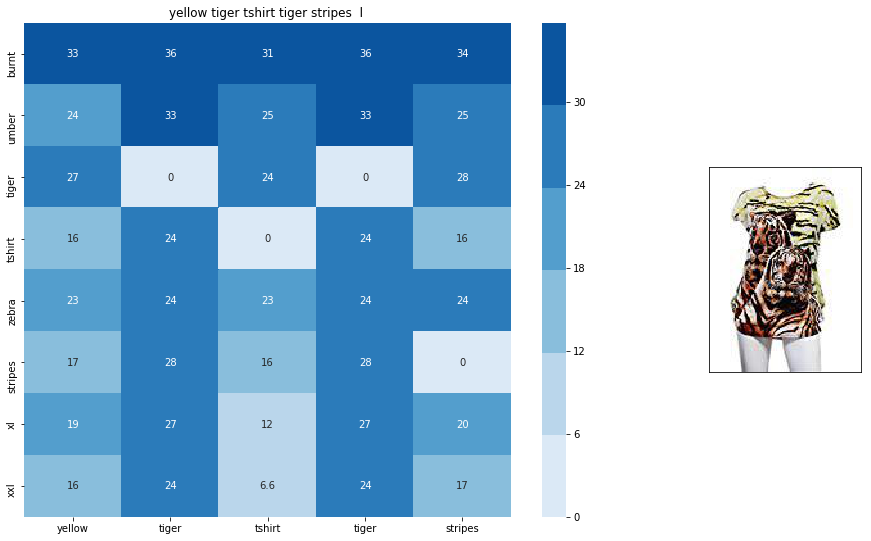

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from input : 6.8966317


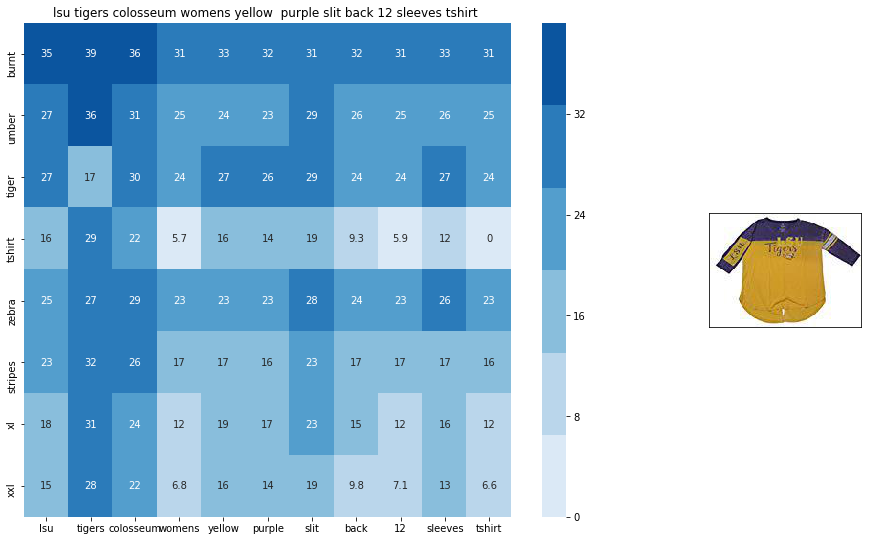

ASIN : B073R5Q8HD
Brand : Colosseum
euclidean distance from input : 6.98962


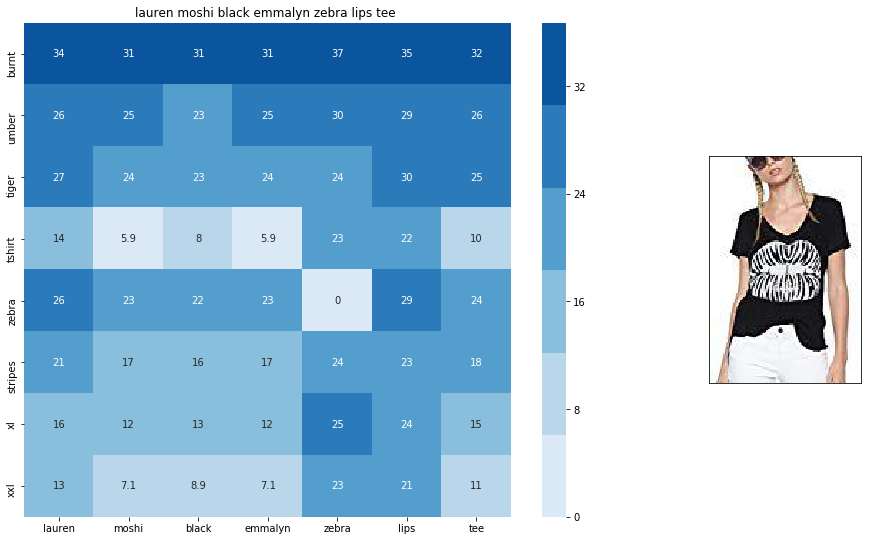

ASIN : B073HPMF8M
Brand : Lauren Moshi
euclidean distance from input : 7.002531


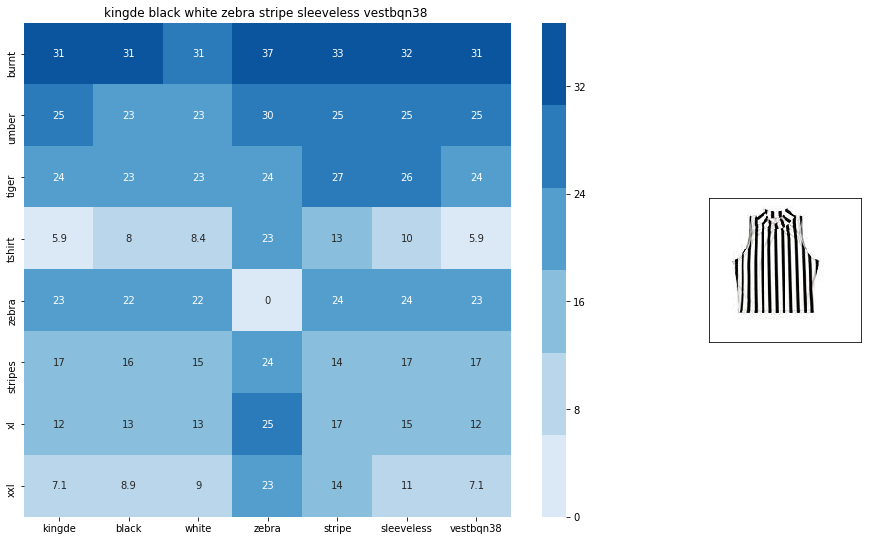

ASIN : B015H41F6G
Brand : KINGDE
euclidean distance from input : 7.0346427


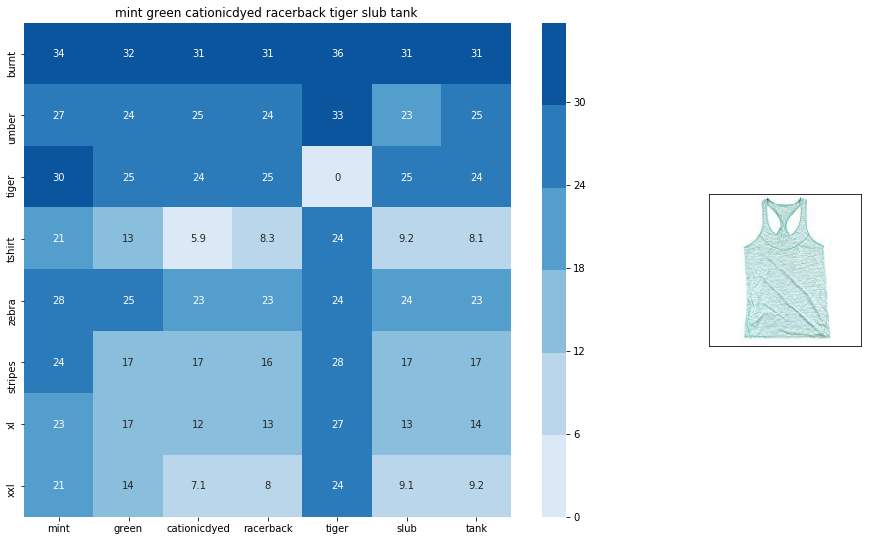

ASIN : B06XCYJC7X
Brand : boxercraft
euclidean distance from input : 7.065138


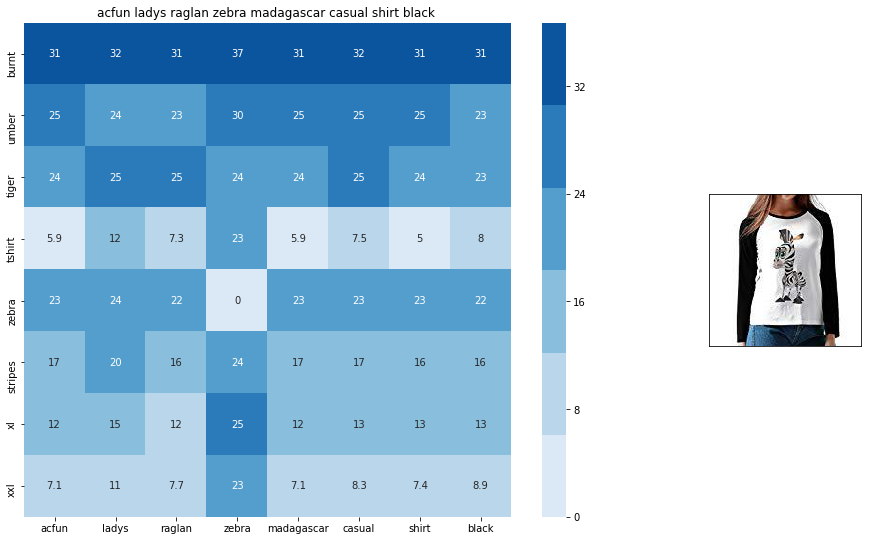

ASIN : B01MAWN1Y7
Brand : ACFUN
euclidean distance from input : 7.0784264


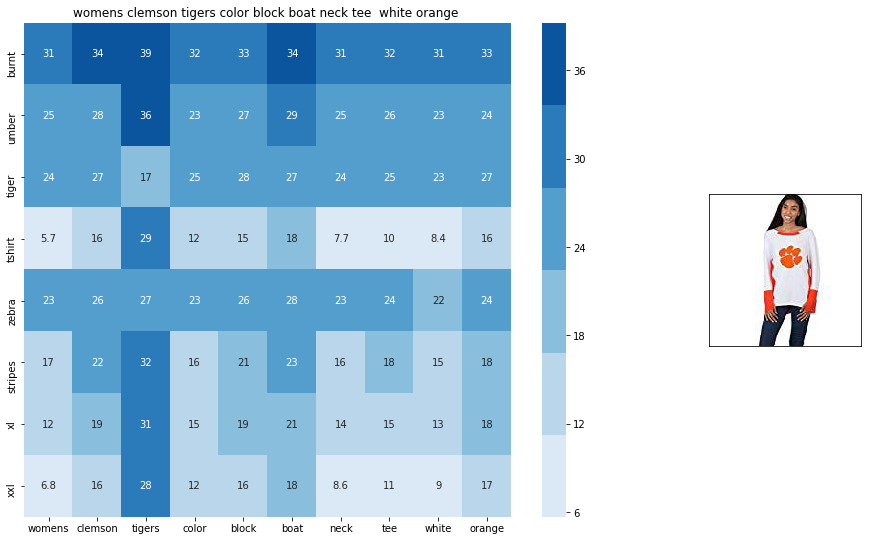

ASIN : B071445KNJ
Brand : Flying Colors
euclidean distance from input : 7.176897


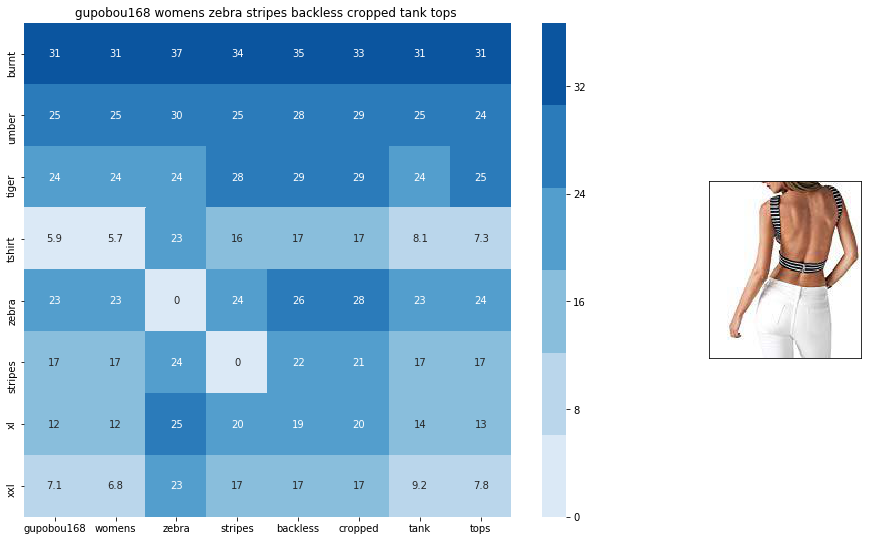

ASIN : B074Z4LF1X
Brand : GuPoBoU168
euclidean distance from input : 7.1846857


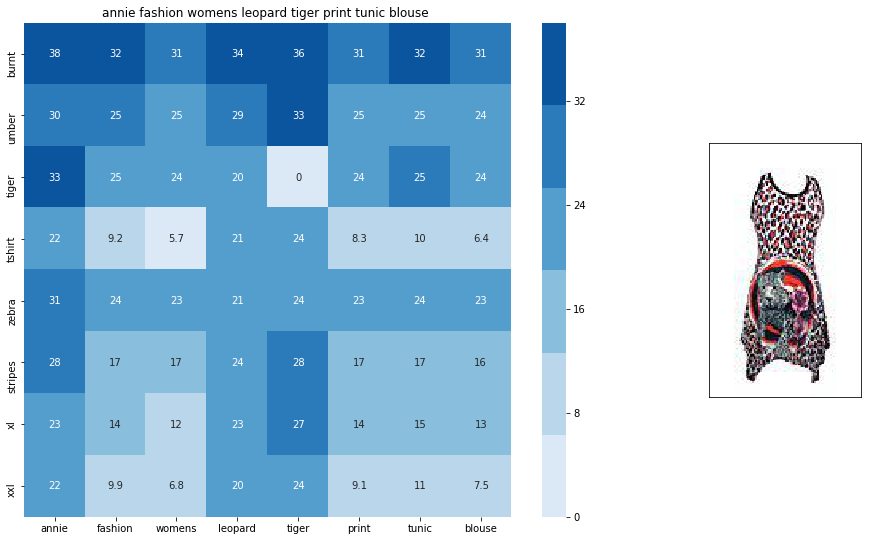

ASIN : B01D21KHVU
Brand : Annie Fashion
euclidean distance from input : 7.191737


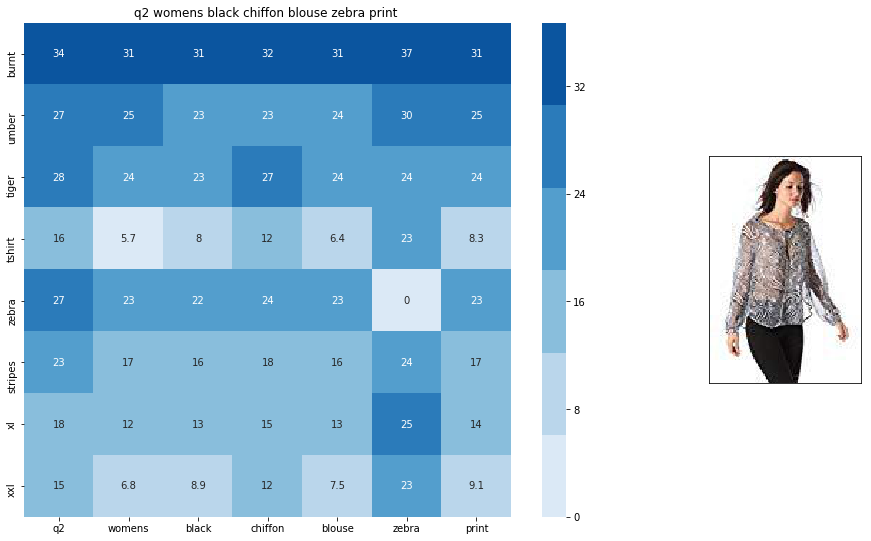

ASIN : B011RYADCM
Brand : Q2
euclidean distance from input : 7.202635


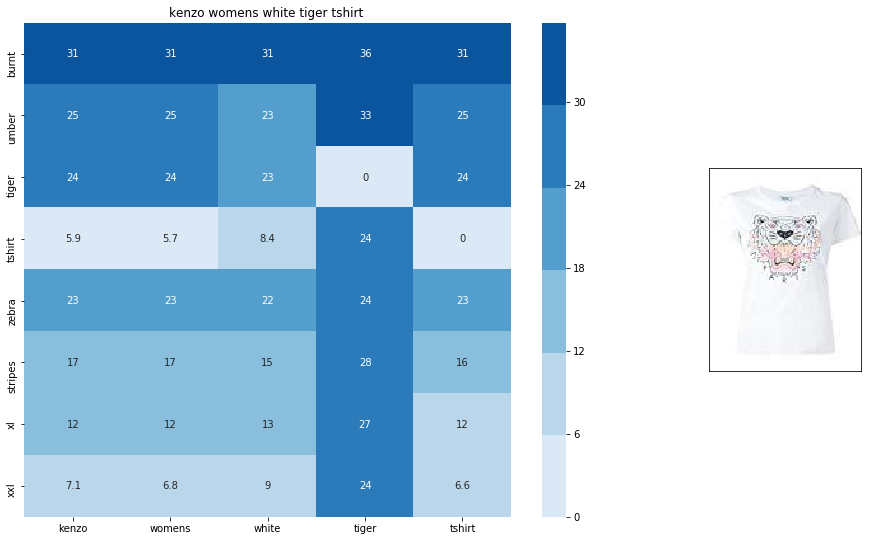

ASIN : B0725YNBG1
Brand : Kenzo
euclidean distance from input : 7.230684


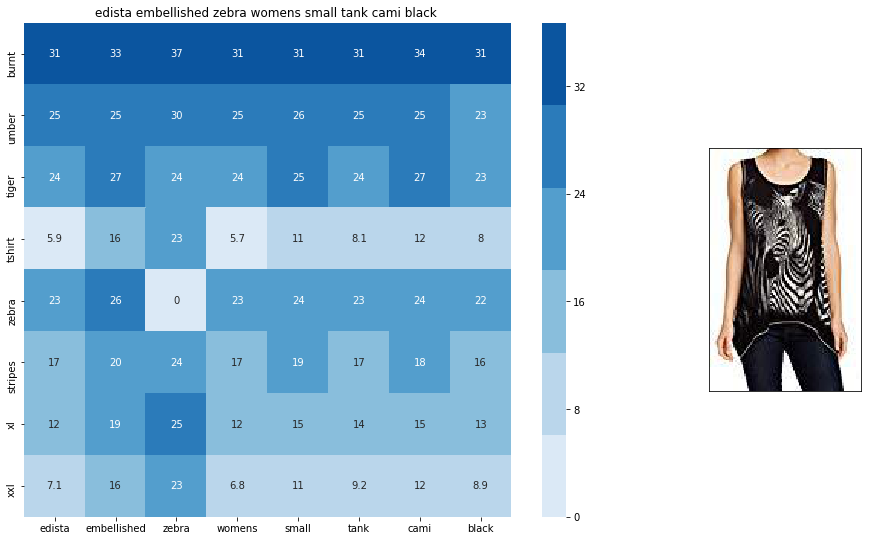

ASIN : B074P8MD22
Brand : Edista
euclidean distance from input : 7.239152


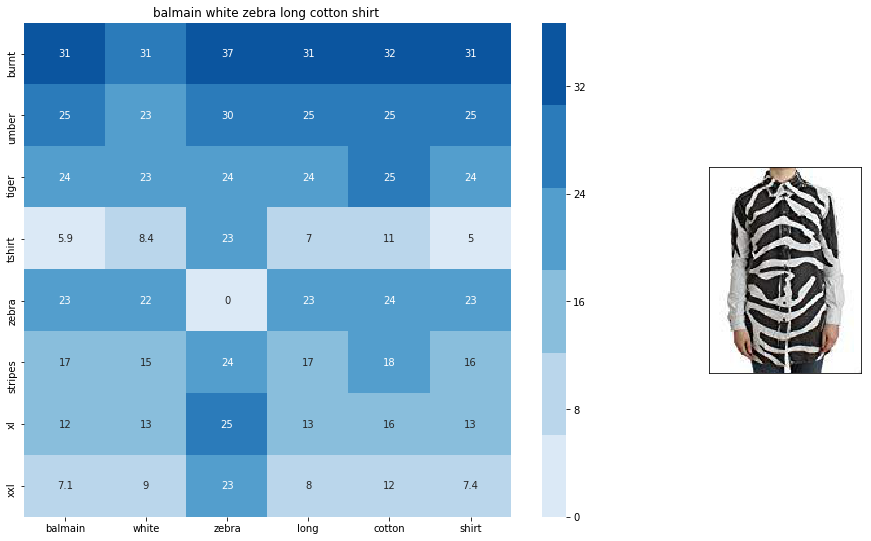

ASIN : B074HR9D1D
Brand : Balmain
euclidean distance from input : 7.2397337


In [175]:
def weighted_w2v_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], df_indices[i], indices[0], indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*60)

weighted_w2v_model(118177, 20)

### [C] Weighted similarity using brand and color.

In [176]:
data['brand'].fillna(value="Not given", inplace=True )

brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [16]:
def heat_map_w2v_brand(sentance1, sentance2, indx, doc_id1, doc_id2, df_id1, df_id2, model):
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], 
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]]
    
    colorscale = [[0, '#0f1626'],[.5, '#a9b7c0'],[1, '#a9b7c0']] 
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    plotly.offline.iplot(table, filename='simple_table')
    
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25, 5))
    
    ax1 = plt.subplot(gs[:, :-5])
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True, cmap=sns.color_palette("Blues"))
    ax1.set_xticklabels(sentance2.split())
    ax1.set_yticklabels(sentance1.split())
    ax1.set_title(sentance2)

    ax2 = plt.subplot(gs[:, 10:16])
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    display_img(indx, ax2, fig)
    
    plt.show()

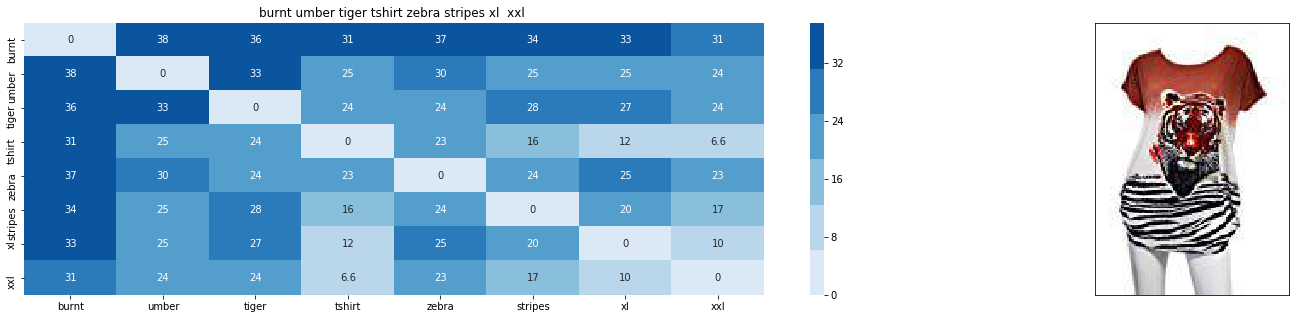

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.001953125


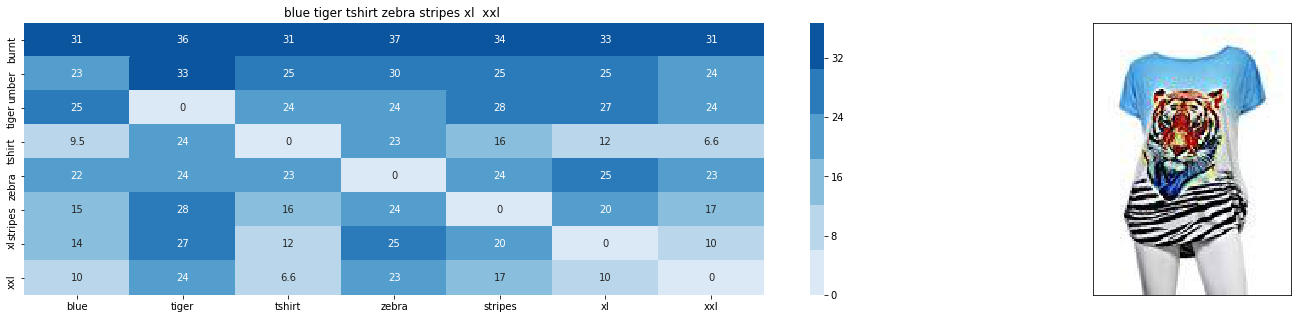

ASIN : B00JXQAKWU
Brand : Si Row
euclidean distance from input : 3.3999870300292967


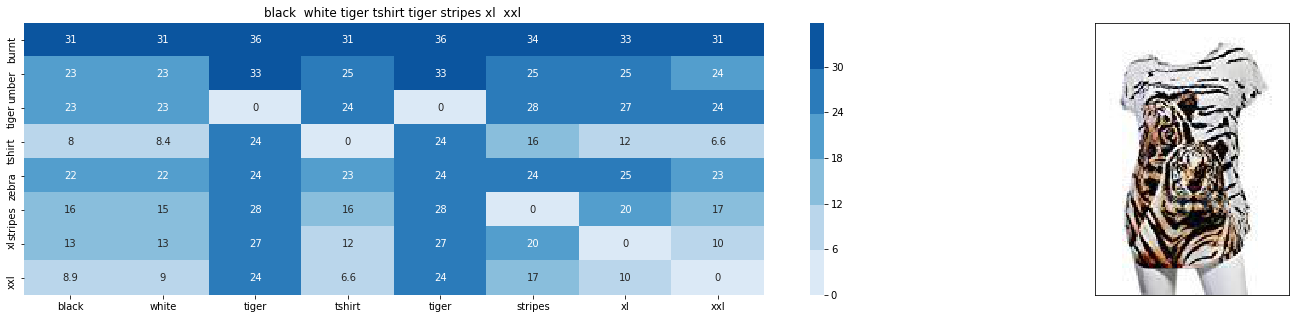

ASIN : B00JXQAC2I
Brand : Si Row
euclidean distance from input : 3.5913372041601805


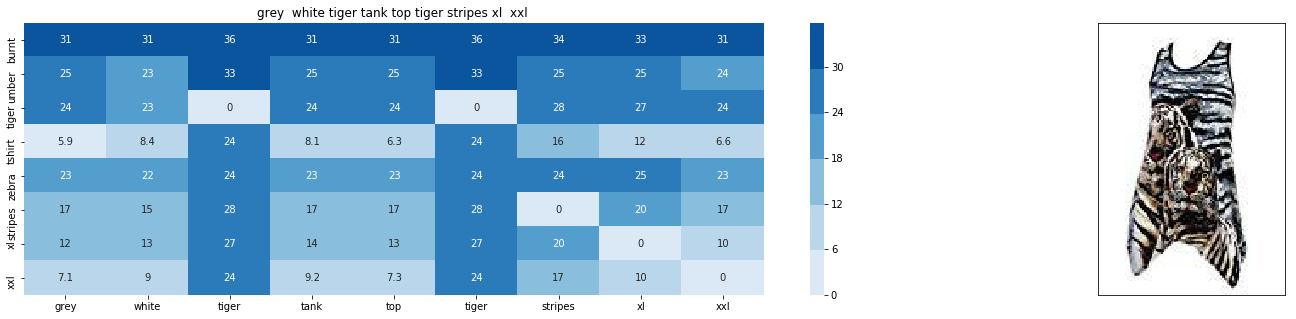

ASIN : B00JXQAFZ2
Brand : Si Row
euclidean distance from input : 3.7269382478613524


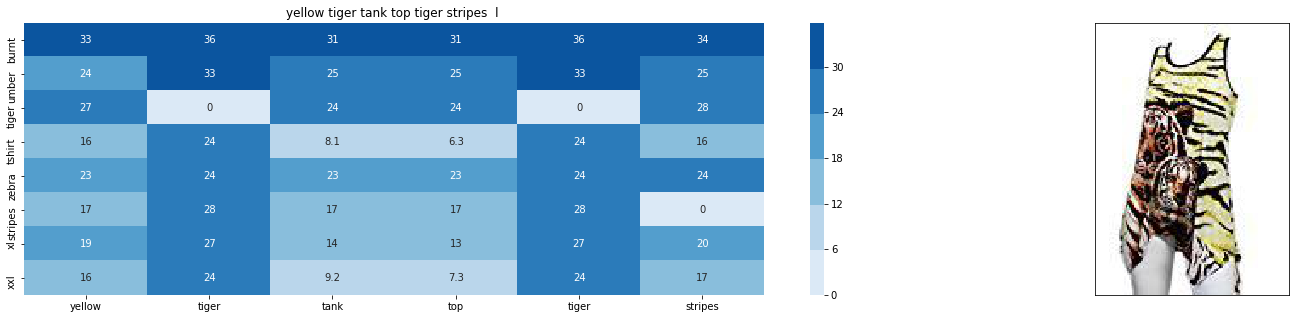

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from input : 4.057775879086938


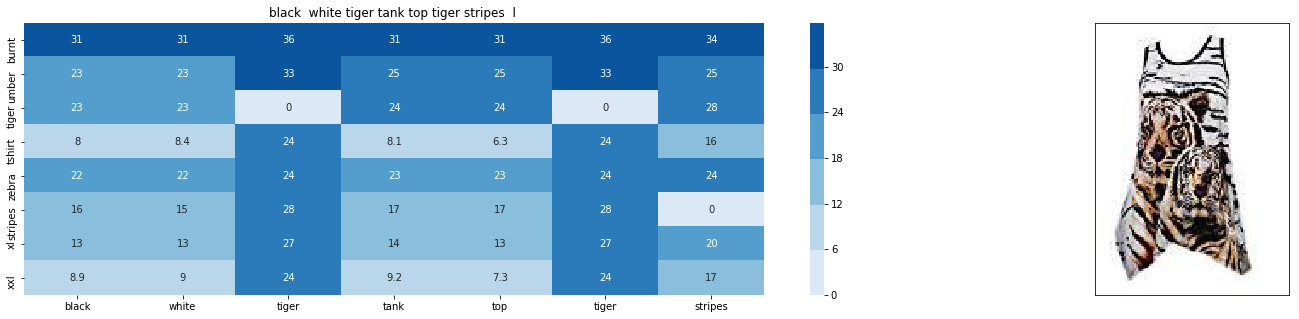

ASIN : B00JXQAO94
Brand : Si Row
euclidean distance from input : 4.058874893369165


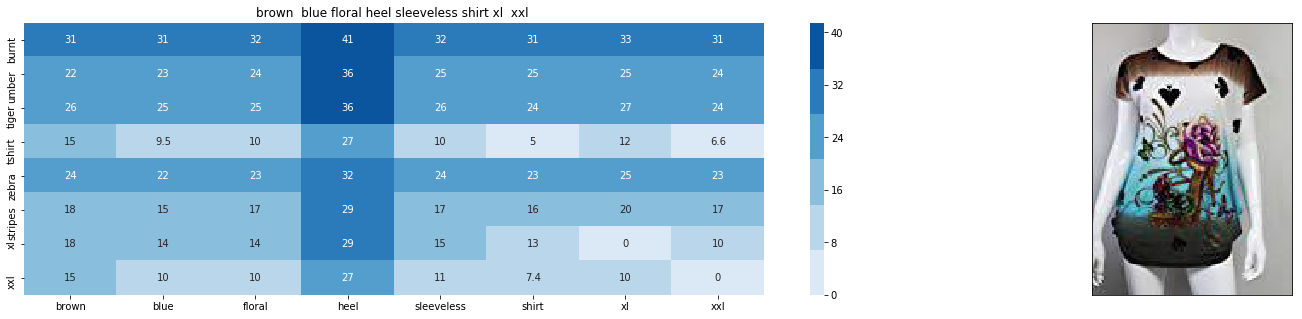

ASIN : B00JV63LGE
Brand : Si Row
euclidean distance from input : 4.102374267578125


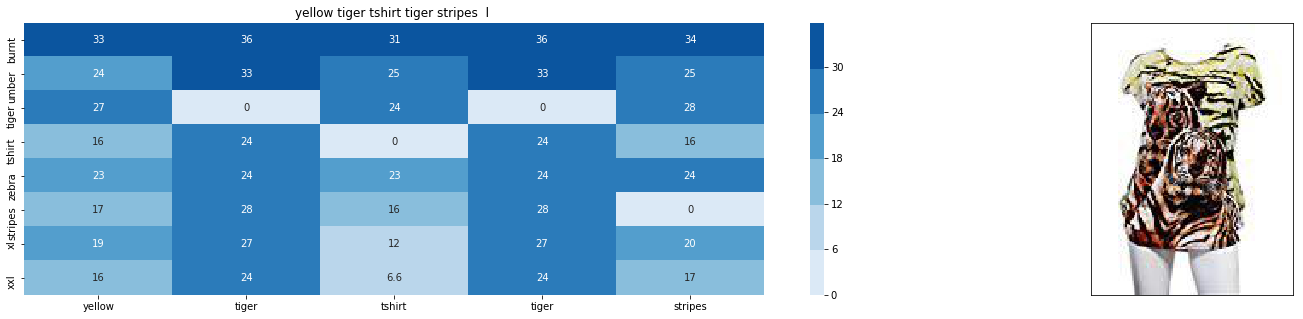

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from input : 4.155422592343774


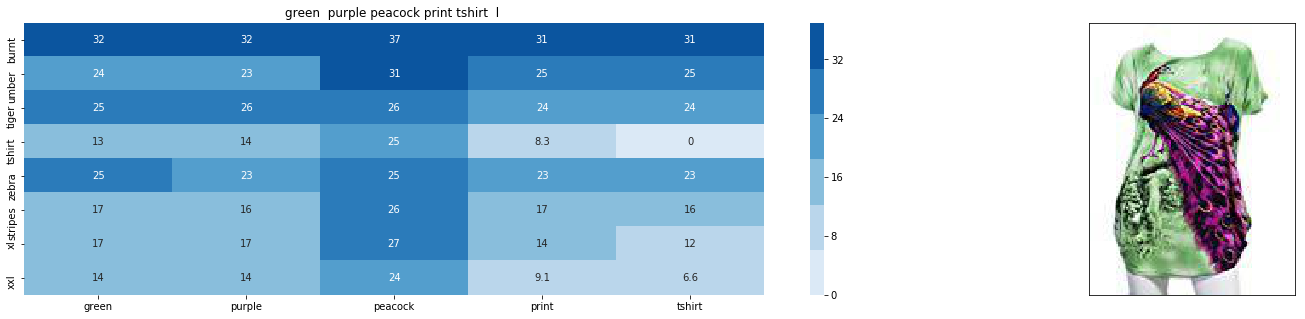

ASIN : B00JXQCN1G
Brand : Si Row
euclidean distance from input : 4.527035141171899


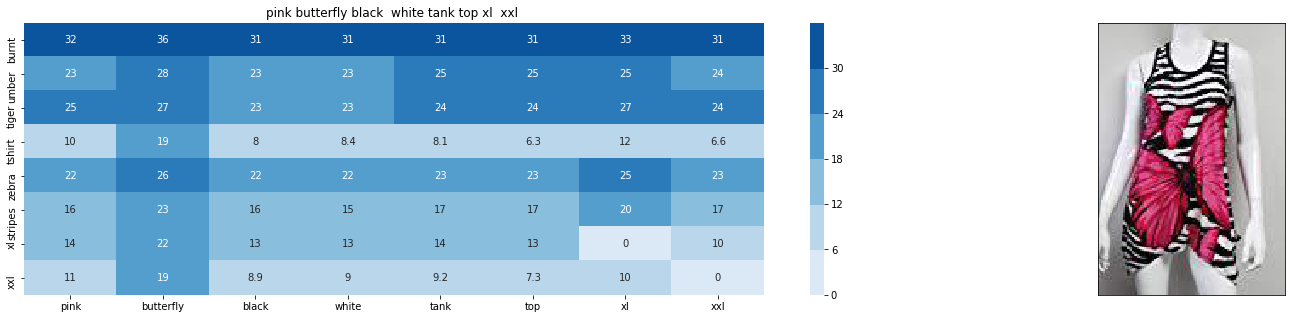

ASIN : B00JV63I62
Brand : Si Row
euclidean distance from input : 4.535824585141626


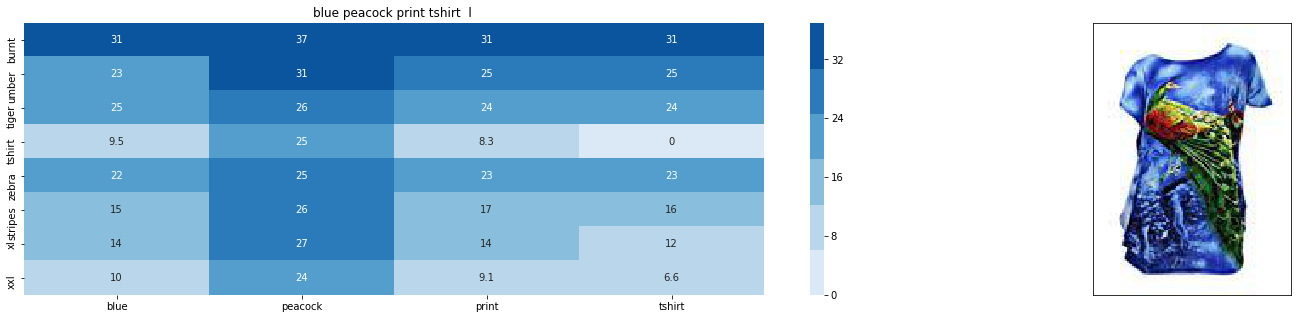

ASIN : B00JXQC8L6
Brand : Si Row
euclidean distance from input : 4.613876724423852


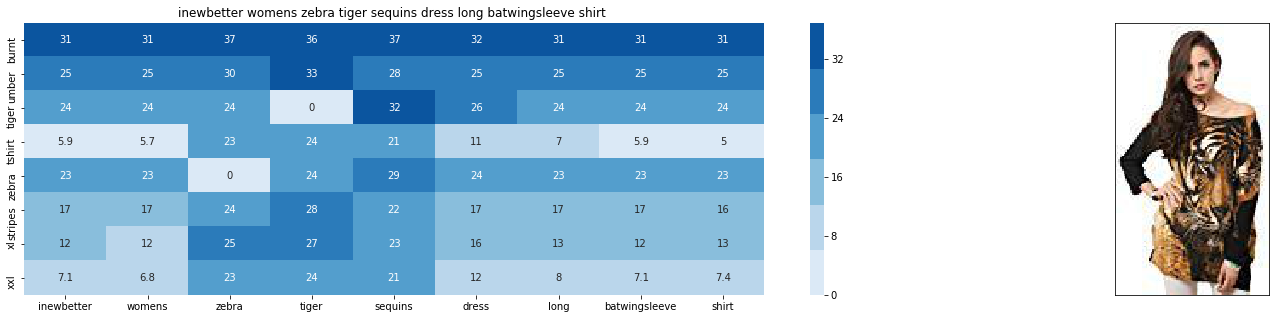

ASIN : B010E86D8K
Brand : iNewbetter
euclidean distance from input : 4.6976631768946


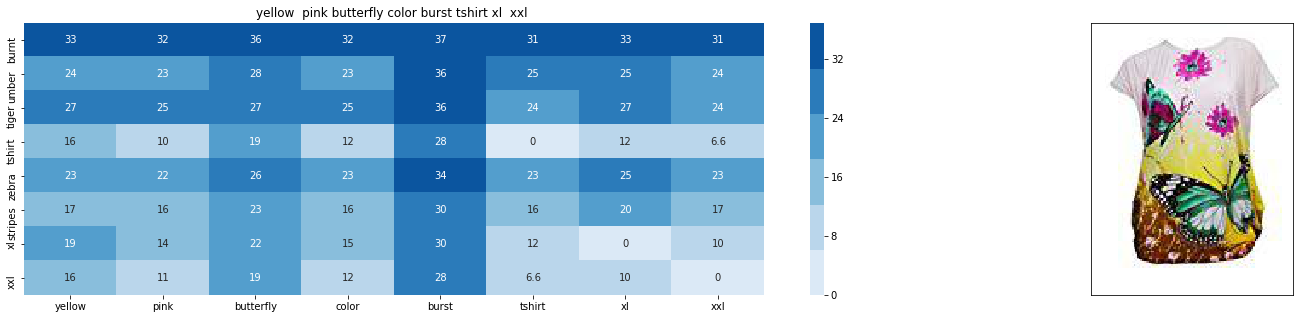

ASIN : B00JXQBBMI
Brand : Si Row
euclidean distance from input : 4.715660858334985


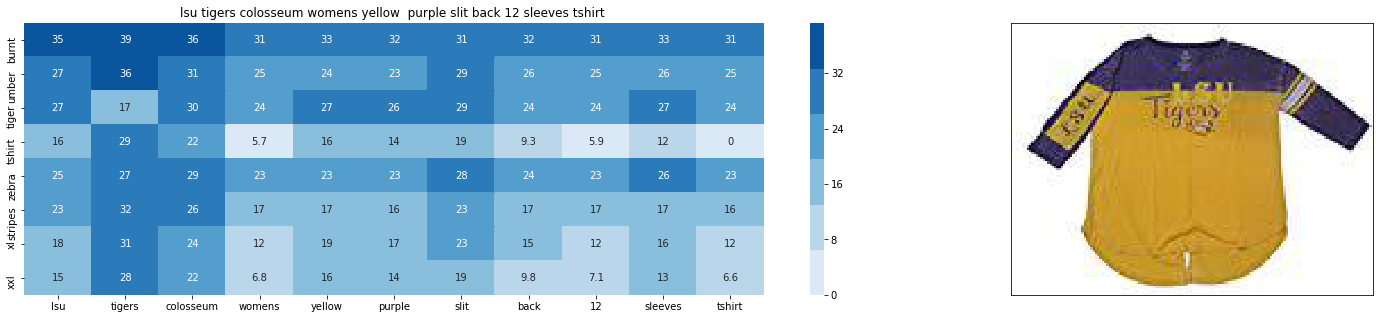

ASIN : B073R5Q8HD
Brand : Colosseum
euclidean distance from input : 4.817685759902412


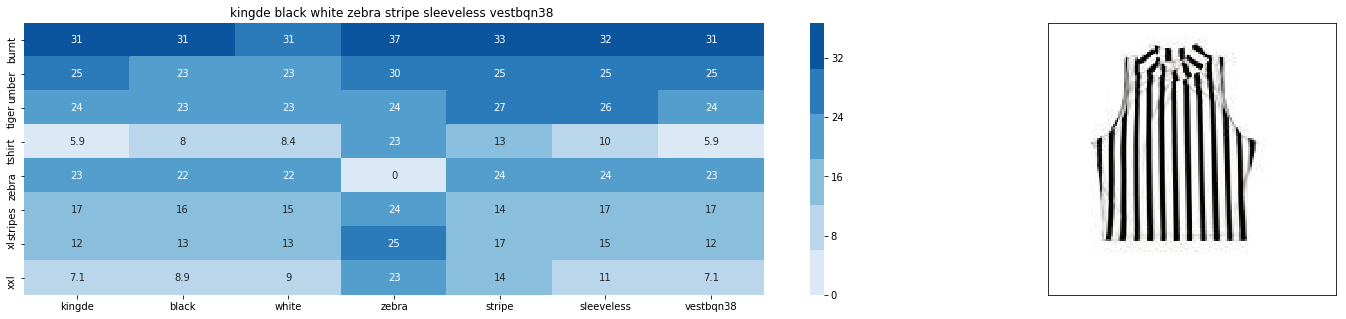

ASIN : B015H41F6G
Brand : KINGDE
euclidean distance from input : 4.840197051406319


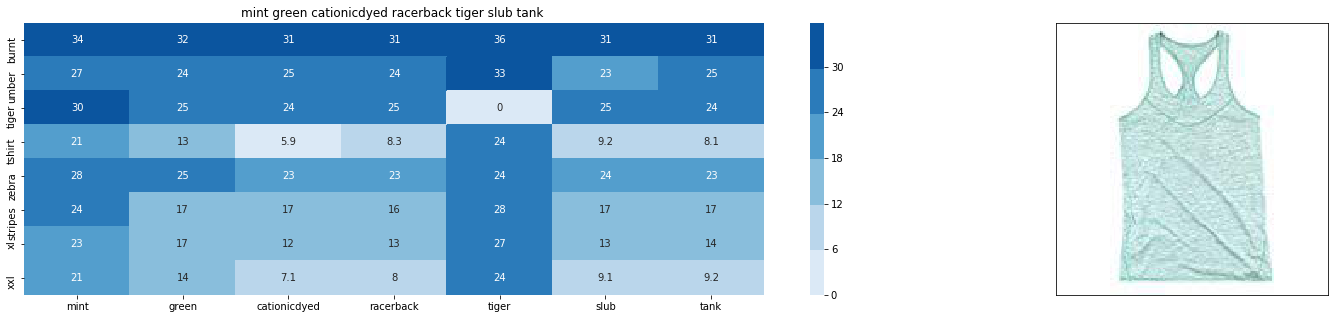

ASIN : B06XCYJC7X
Brand : boxercraft
euclidean distance from input : 4.855444777846748


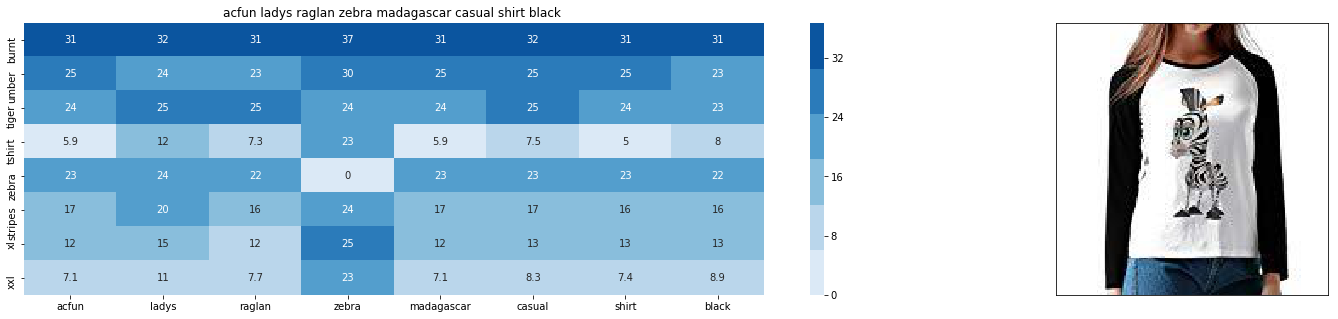

ASIN : B01MAWN1Y7
Brand : ACFUN
euclidean distance from input : 4.862088836074287


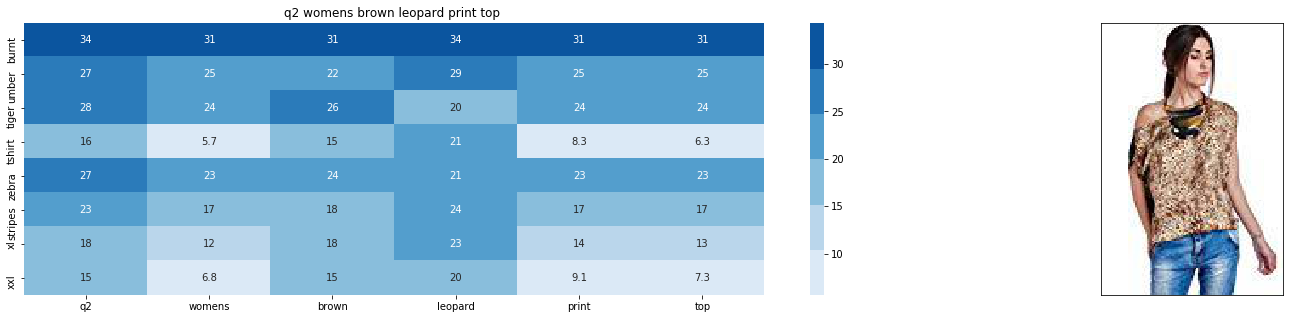

ASIN : B00V51U27O
Brand : Q2
euclidean distance from input : 4.868885047709855


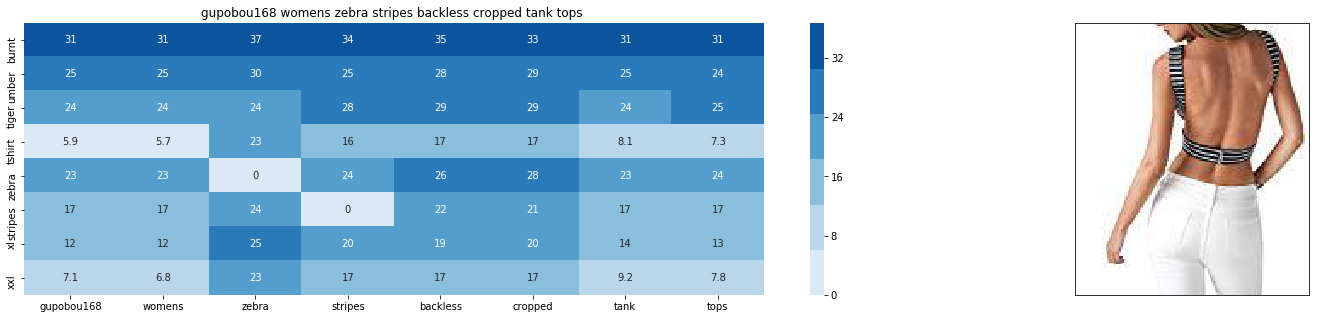

ASIN : B074Z4LF1X
Brand : GuPoBoU168
euclidean distance from input : 4.915218413711006


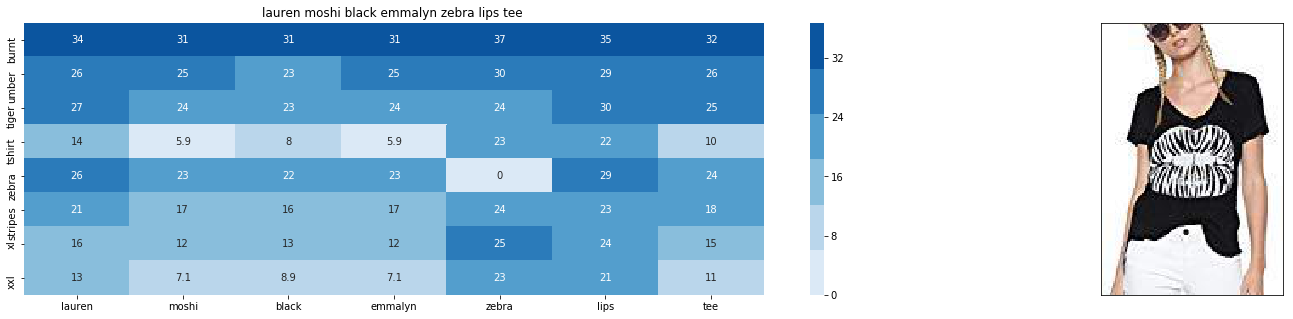

ASIN : B073HPMF8M
Brand : Lauren Moshi
euclidean distance from input : 4.9154792789258295


In [188]:
def idf_w2v_brand(doc_id, w1, w2, num_results):
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist)/float(w1 + w2)
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], df_indices[i], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*60)

idf_w2v_brand(118177, 5, 5, 20)

## 8. Visual features based product similarity

In [189]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

Using TensorFlow backend.


In [193]:
from tqdm import tqdm

asin_list = data.asin.values
img_files = os.listdir('../image/')
for img_file in tqdm(img_files):
    if img_file.strip('image.jpeg') not in asin_list:
        os.remove('../image/' + img_file)

100%|██████████| 183138/183138 [33:00<00:00, 92.47it/s]  


(**Note :** From here I'll be using only 16k datapoints as now on computations are too much expensive and time taking.)

In [8]:
# dimensions of our images.
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'images2/'
nb_train_samples = 16042
epochs = 50
batch_size = 1


def save_bottlebeck_features():
    
    #Function to compute VGG-16 CNN for image feature extraction.
    
    asins = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    for i in generator.filenames:
        asins.append(i[2:-5])

    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    bottleneck_features_train = bottleneck_features_train.reshape((16042,25088))
    
    np.save(open('16k_data_cnn_features.npy', 'wb'), bottleneck_features_train)
    np.save(open('16k_data_cnn_feature_asins.npy', 'wb'), np.array(asins))
    

save_bottlebeck_features()

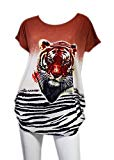

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 0.0625
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


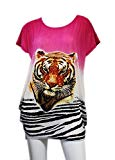

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 30.050072
Amazon Url: www.amzon.com/dp/B00JXQASS6


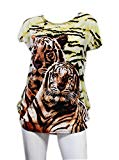

Product Title:  yellow tiger tshirt tiger stripes  l 
Euclidean Distance from input image: 41.261078
Amazon Url: www.amzon.com/dp/B00JXQCUIC


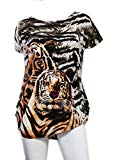

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean Distance from input image: 44.000187
Amazon Url: www.amzon.com/dp/B00JXQCWTO


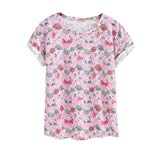

Product Title:  kawaii pastel tops tees pink flower design 
Euclidean Distance from input image: 47.38251
Amazon Url: www.amzon.com/dp/B071FCWD97


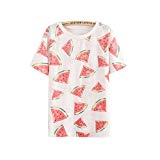

Product Title:  womens thin style tops tees pastel watermelon print 
Euclidean Distance from input image: 47.718403
Amazon Url: www.amzon.com/dp/B01JUNHBRM


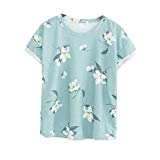

Product Title:  kawaii pastel tops tees baby blue flower design 
Euclidean Distance from input image: 47.9021
Amazon Url: www.amzon.com/dp/B071SBCY9W


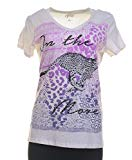

Product Title:  edv cheetah run purple multi xl 
Euclidean Distance from input image: 48.046516
Amazon Url: www.amzon.com/dp/B01CUPYBM0


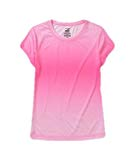

Product Title:  danskin womens vneck loose performance tee xsmall pink ombre 
Euclidean Distance from input image: 48.101917
Amazon Url: www.amzon.com/dp/B01F7PHXY8


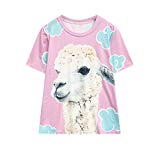

Product Title:  summer alpaca 3d pastel casual loose tops tee design 
Euclidean Distance from input image: 48.118877
Amazon Url: www.amzon.com/dp/B01I80A93G


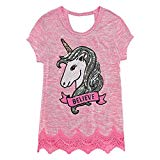

Product Title:  miss chievous juniors striped peplum tank top medium shadowpeach 
Euclidean Distance from input image: 48.13129
Amazon Url: www.amzon.com/dp/B0177DM70S


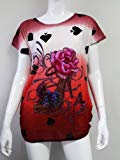

Product Title:  red  pink floral heel sleeveless shirt xl  xxl 
Euclidean Distance from input image: 48.16947
Amazon Url: www.amzon.com/dp/B00JV63QQE


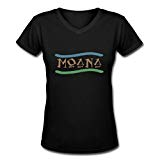

Product Title:  moana logo adults hot v neck shirt black xxl 
Euclidean Distance from input image: 48.25679
Amazon Url: www.amzon.com/dp/B01LX6H43D


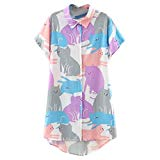

Product Title:  abaday multicolor cartoon cat print short sleeve longline shirt large 
Euclidean Distance from input image: 48.265633
Amazon Url: www.amzon.com/dp/B01CR57YY0


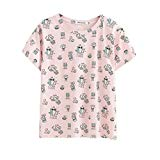

Product Title:  kawaii cotton pastel tops tees peach pink cactus design 
Euclidean Distance from input image: 48.362583
Amazon Url: www.amzon.com/dp/B071WYLBZS


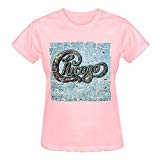

Product Title:  chicago chicago 18 shirt women pink 
Euclidean Distance from input image: 48.383617
Amazon Url: www.amzon.com/dp/B01GXAZTRY


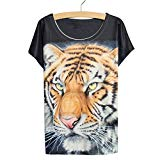

Product Title:  yichun womens tiger printed summer tshirts tops 
Euclidean Distance from input image: 48.449303
Amazon Url: www.amzon.com/dp/B010NN9RXO


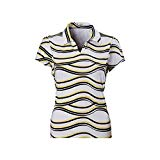

Product Title:  nancy lopez whimsy short sleeve  whiteblacklemon drop  xs 
Euclidean Distance from input image: 48.478912
Amazon Url: www.amzon.com/dp/B01MPX6IDX


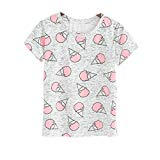

Product Title:  womens tops tees pastel peach ice cream cone print 
Euclidean Distance from input image: 48.557964
Amazon Url: www.amzon.com/dp/B0734GRKZL


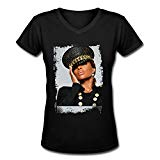

Product Title:  uswomens mary j blige without tshirts shirt 
Euclidean Distance from input image: 48.614376
Amazon Url: www.amzon.com/dp/B01M0XXFKK


In [5]:
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('../16k_data_cnn_features.npy')
asins = np.load('../16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('../16k_apperal_data_preprocessed')
df_asins = list(data['asin'])


from IPython.display import display, Image, Math


#get similar products using CNN features (VGG-16)
def get_similar_products_cnn(doc_id, num_results):
    doc_id = asins.index(df_asins[doc_id])
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

get_similar_products_cnn(12566, 20)

## 9. Weighted features based product similarity

In [21]:
data = pd.read_pickle('../16k_apperal_data_preprocessed')

In [22]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

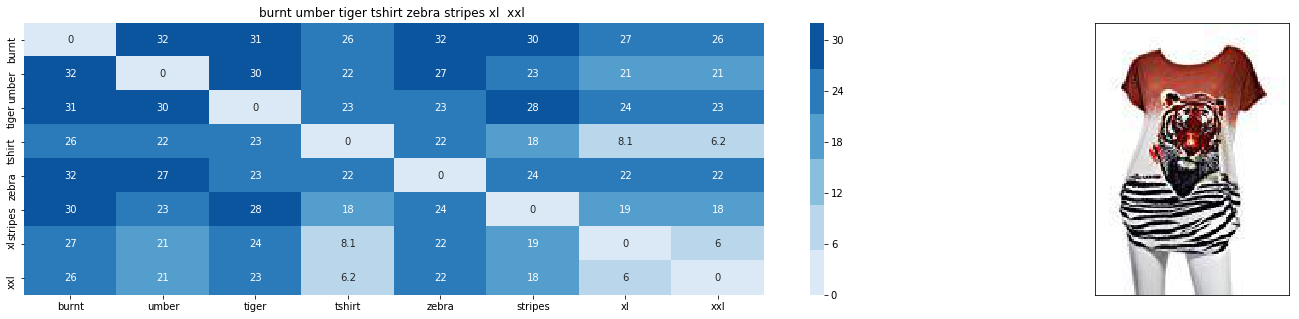

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.0027621358167380095


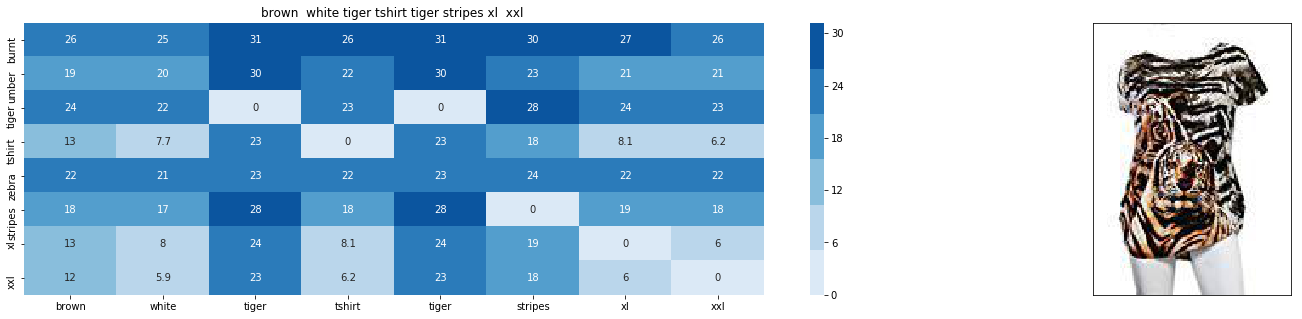

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from input : 3.47174334526062


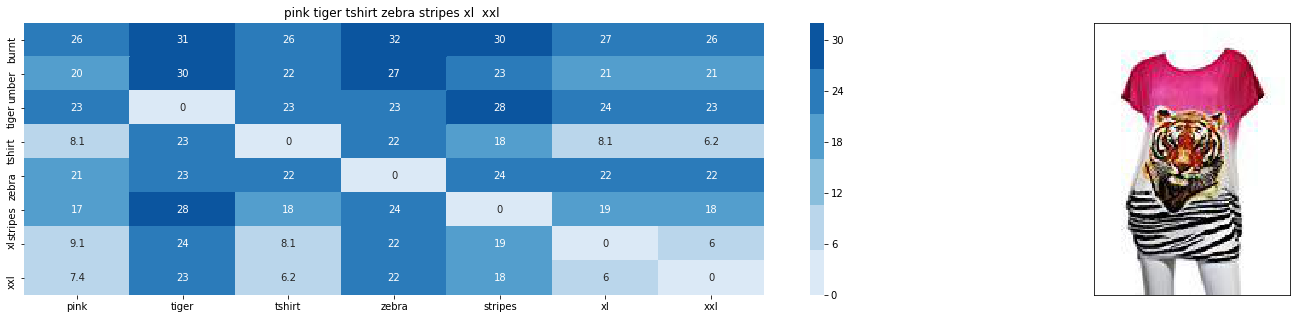

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from input : 3.4738140107330473


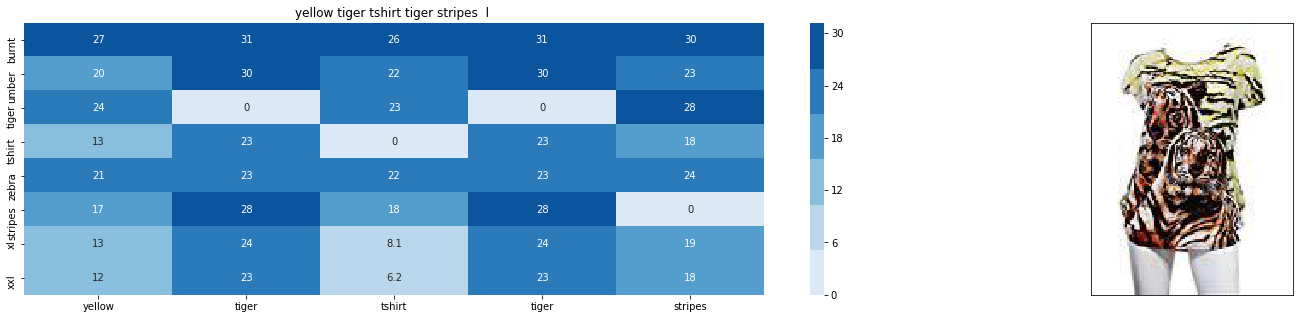

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from input : 3.7030055524048002


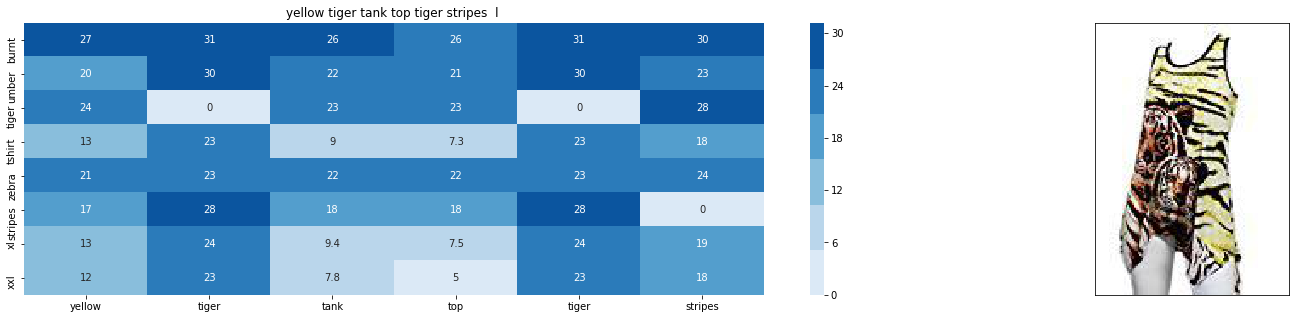

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from input : 3.784372091406265


In [77]:
def idf_total(doc_id, w1, w2, w3, w4, num_results):
    cnn_feat_dist  = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1, -1))
    color_feat_dist = pairwise_distances(extra_features[:, 3890:], extra_features[doc_id, 3890:])
    brand_feat_dist = pairwise_distances(extra_features[:, :3835], extra_features[doc_id, :3835])
    type_feat_dist = pairwise_distances(extra_features[:, 3835:3890], extra_features[doc_id, 3835:3890])
    
    pairwise_dist   = (w1 * cnn_feat_dist +  w2 * color_feat_dist + w3 * brand_feat_dist + w4 * type_feat_dist)/float(w1 + w2 + w3 + w4)
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], df_indices[i], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*60)

idf_total(12566, 1, 5, 5, 5, 5)

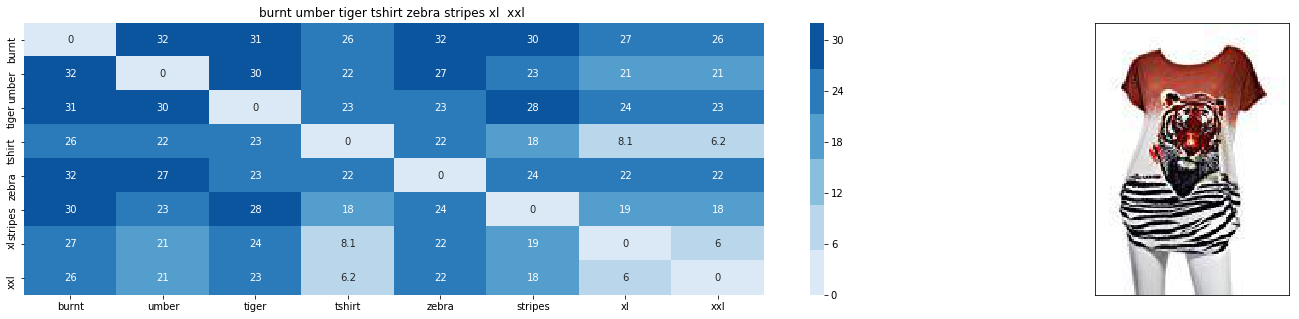

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.0031567266477005823


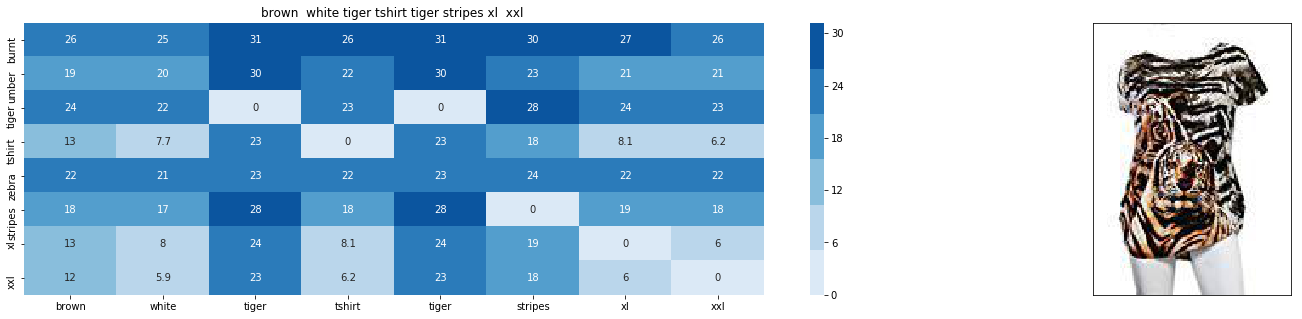

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from input : 3.9677066802978516


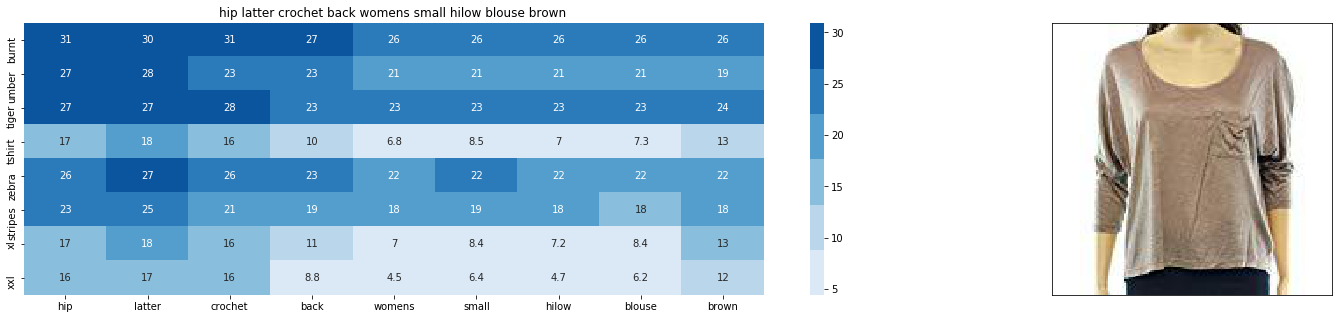

ASIN : B074MJN1K9
Brand : Hip
euclidean distance from input : 4.044747409243322


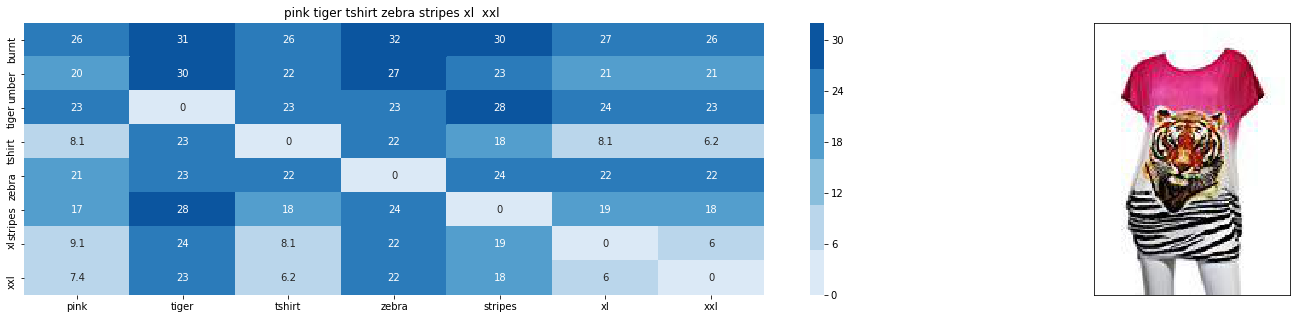

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from input : 4.071088409578704


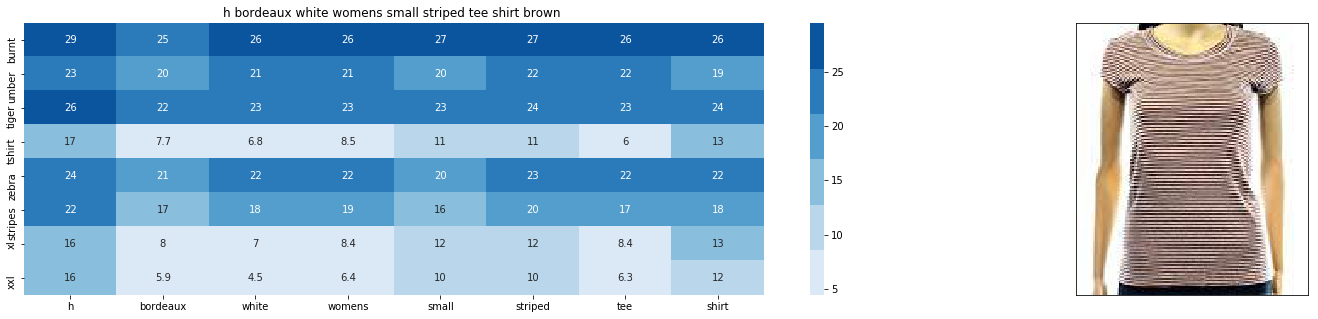

ASIN : B072BVB47Z
Brand : H By Bordeaux
euclidean distance from input : 4.1382903508552


In [83]:
idf_total(12566, 2, 12, 8, 6, 5)

## 10. Conclusion:
* Every Feature did well as the recommended products are pretty much similar.
* By using weighed features we can actually handle what kind of products we want to show to the customer.